# U-net 13x under-sampling

# This was done in  Google cloud, using V100 GPUs

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2
import h5py

# Data Preparation

Note that I had to deal with several data coming from different places in different formats. I used Jupyter notebook to prepare the data and then run the network also using the jupyter notebook.

In [2]:
# Reading the training data
data_recon = h5py.File('data/TrainingData_tGA_Radial_recon.mat', 'r')
data_truth = h5py.File('data/TrainingData_tGA_Radial_truth.mat', 'r')
# See the keys
print(data_recon.keys())
print(data_truth.keys())

<KeysViewHDF5 ['imagesRecon']>
<KeysViewHDF5 ['imagesTrue']>


In [3]:
# getting the data out of the dict format
data_recon = data_recon['imagesRecon']
data_truth = data_truth['imagesTrue']

In [4]:
# Checking the shape of data
print("data_recon shape: ", data_recon.shape)
print("data_truth shape: ", data_truth.shape)

data_recon shape:  (2268, 128, 128, 20)
data_truth shape:  (2268, 128, 128, 20)


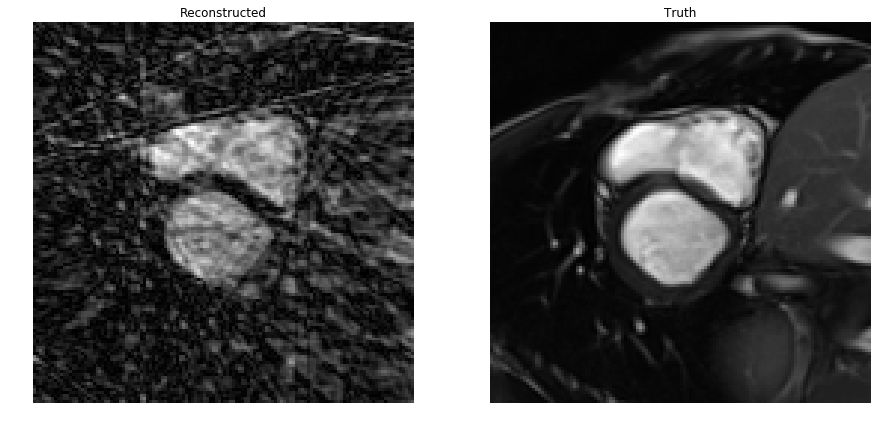

In [5]:
# Let's look at a smaple data
f, arr = plt.subplots(1,2,figsize=(15,15))
arr[0].imshow(data_recon[0,:,:,0], cmap='gray')
arr[0].set_title("Reconstructed")
arr[0].axis('off')
arr[1].imshow(data_truth[0,:,:,0], cmap='gray')
arr[1].set_title("Truth")
arr[1].axis('off');

In [6]:
# Resizing the data so that they have 1 channel (grayscale)
data_recon_channel = np.ndarray((1200, 1, 128, 128, 20))
data_recon_channel[:,0,:,:,:] = data_recon[0:1200,:,:,:]
data_recon = data_recon_channel[0:1200,:,:,:]
print("data_recon shape: ", data_recon.shape)
del data_recon_channel

data_truth_channel = np.ndarray((1200, 1, 128, 128, 20))
data_truth_channel[:,0,:,:,:] = data_truth[0:1200,:,:,:]
data_truth = data_truth_channel[0:1200,:,:,:]
print("data_truth shape: ", data_truth.shape)
del data_truth_channel

data_recon shape:  (1200, 1, 128, 128, 20)
data_truth shape:  (1200, 1, 128, 128, 20)


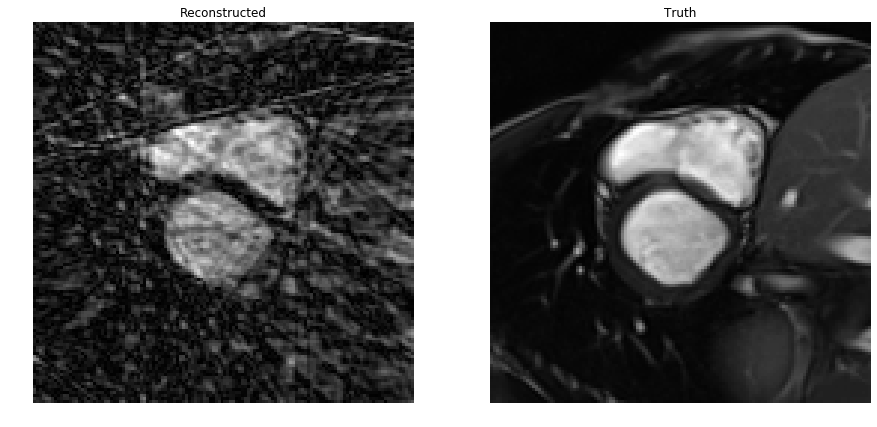

In [7]:
# Let's look at a smaple data again to check everything is the same
f, arr = plt.subplots(1,2,figsize=(15,15))
arr[0].imshow(data_recon[0,0,:,:,0], cmap='gray')
arr[0].set_title("Reconstructed")
arr[0].axis('off')
arr[1].imshow(data_truth[0,0,:,:,0], cmap='gray')
arr[1].set_title("Truth")
arr[1].axis('off');

In [8]:
# Importing pytorch framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# converting numpy to tesnor
data_recon = torch.from_numpy(data_recon)
data_truth = torch.from_numpy(data_truth)

In [12]:
# Test data
test_data = h5py.File('data/TestData_tGA_Radial.mat', 'r')
# See the keys
print(test_data.keys())

<KeysViewHDF5 ['imagesRecon', 'imagesTrue']>


In [13]:
test_recon = test_data['imagesRecon']
test_true = test_data['imagesTrue']
del test_data

In [14]:
print("test_recon shape: ", test_recon.shape)
print("test_true shape: ", test_true.shape)

test_recon shape:  (222, 128, 128, 20)
test_true shape:  (222, 128, 128, 20)


In [15]:
# Resizing the data so that they have 1 channel (grayscale)
test_recon_channel = np.ndarray((222, 1, 128, 128, 20))
test_recon_channel[:,0,:,:,:] = test_recon
test_recon = test_recon_channel
print("test_recon shape: ", test_recon.shape)
del test_recon_channel

test_truth_channel = np.ndarray((222, 1, 128, 128, 20))
test_truth_channel[:,0,:,:,:] = test_true
test_true = test_truth_channel
print("data_true shape: ", test_true.shape)
del test_truth_channel

test_recon shape:  (222, 1, 128, 128, 20)
data_true shape:  (222, 1, 128, 128, 20)


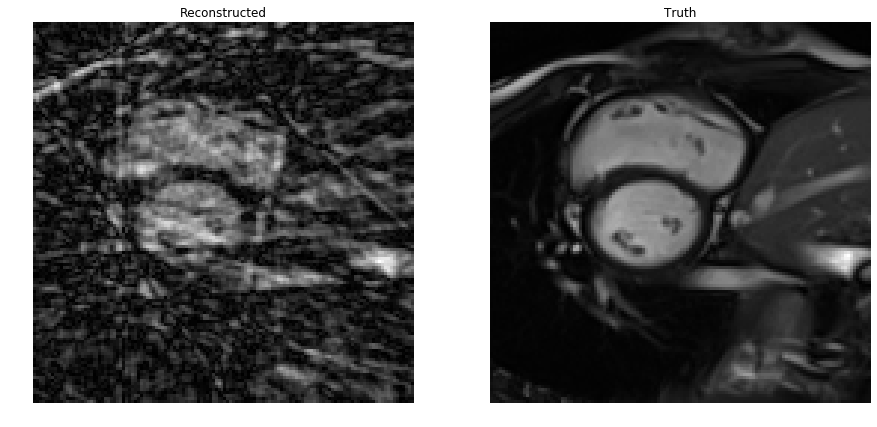

In [16]:
# Let's look at a smaple data again to check everything is the same
f, arr = plt.subplots(1,2,figsize=(15,15))
arr[0].imshow(test_recon[0,0,:,:,0], cmap='gray')
arr[0].set_title("Reconstructed")
arr[0].axis('off')
arr[1].imshow(test_true[0,0,:,:,0], cmap='gray')
arr[1].set_title("Truth")
arr[1].axis('off');

In [17]:
test_true = torch.from_numpy(test_true)
test_recon = torch.from_numpy(test_recon)

# U-net model

In [18]:
class unet(nn.Module):
    """
    Implementation of the U-net as in the Hauptmann et al.
    --------------
    inputs = Aliased data, 4D tensor, shape: (N_batch, N_channels, depth, height, width)
    The order of the depth, height and width doesn't really matter.
    --------------
    outputs---> De-aliased data, 4D tensor, shape(N_batch, N_channels, depth, height, width)    
    """
    def __init__(self, input_channel=1, first_output_channel=32, kernel_size=3):
        super(unet, self).__init__()
        self.kernel_size = kernel_size
        # All the convolutions used. The subscript is the level going down until to 3
        # and then goes upwards 
        # convi_i is the same convolution as i repeated but differnet input channels

        self.conv1 = nn.Conv3d(input_channel, first_output_channel, kernel_size, padding=1)
        # Default: self.conv1 = nn.Conv3d(1, 32, kernel_size, padding=1)
        self.conv1_1 = nn.Conv3d(first_output_channel, first_output_channel, kernel_size, padding=1)
        # Notice the differnece in the input channel compared to previous one

        self.conv2 = nn.Conv3d(first_output_channel, first_output_channel*2, kernel_size, padding=1)
        # Default: self.conv2 = nn.Conv3d(32, 64, kernel_size, padding=1)
        self.conv2_2 = nn.Conv3d(first_output_channel*2, first_output_channel*2, kernel_size, padding=1)

        self.conv3 = nn.Conv3d(first_output_channel*2, first_output_channel*2*2, kernel_size, padding=1)
        # Default: self.conv3 = nn.Conv3d(64, 128, kernel_size, padding=1)
        self.conv3_3 = nn.Conv3d(128, 128, kernel_size, padding=1)

        self.conv4 = nn.Conv3d(first_output_channel*2*2, first_output_channel*2, kernel_size, padding=1)
        # Default: self.conv4 = nn.Conv3d(128, 64, kernel_size, padding=1)
        self.conv4_4 = nn.Conv3d(first_output_channel*2, first_output_channel*2, kernel_size, padding=1)

        self.conv5 = nn.Conv3d(first_output_channel*2, first_output_channel, kernel_size, padding=1)
        # Default: self.conv5 = nn.Conv3d(64, 32, kernel_size, padding=1)
        self.conv5_5 = nn.Conv3d(first_output_channel, first_output_channel, kernel_size, padding=1)

        self.conv6 = nn.Conv3d(first_output_channel, input_channel , kernel_size, padding=1)
        # Default: self.conv6 = nn.Conv3d(32, 1 , kernel_size, padding=1)
        
        # Transposed convolutions for upsampling
        self.convT1 = nn.ConvTranspose3d(first_output_channel*2*2, first_output_channel*2, kernel_size, stride=(2,2,2), padding=1, output_padding=1)
        # Default: self.convT1 = nn.ConvTranspose3d(128, 64, kernel_size, stride=(2,2,2), padding=1, output_padding=1)
        self.convT2 = nn.ConvTranspose3d(first_output_channel*2, first_output_channel, kernel_size, stride=(2,2,2), padding=1, output_padding=1)
        # Default: self.convT2 = nn.ConvTranspose3d(64, 32, kernel_size, stride=(2,2,2), padding=1, output_padding=1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, inputs):
        """
        1- Convolution, Convolution, pooling
        2- Convolution, Convolution, pooling
        3- Convolution, Convolution, upsampling
        4- Convolution, Convolution, upsampling
        5- Convolution, Convolution, Convolution
        6- Skip connection, Relu
        """
        conv1 = self.relu(self.conv1(inputs))
        conv1 = self.relu(self.conv1_1(conv1))
        pool1 = F.max_pool3d(conv1, 2)
        
        conv2 = self.relu(self.conv2(pool1))
        conv2 = self.relu(self.conv2_2(conv2))
        pool2 = F.max_pool3d(conv2, 2)   

        conv3 = self.relu(self.conv3(pool2))
        conv3 = self.relu(self.conv3_3(conv3))        
        conv3 = self.convT1(conv3)
        
        up1 = torch.cat((conv3, conv2), dim=1)

        conv4 = self.relu(self.conv4(up1))
        conv4 = self.relu(self.conv4_4(conv4))
        
        conv4 = self.convT2(conv4)

        up2 = torch.cat((conv4, conv1), dim=1)

        conv5 = self.relu(self.conv5(up2))
        conv5 = self.relu(self.conv5_5(conv5))
        
        conv6 = self.relu(self.conv6(conv5) + inputs)
        # conv6 is the output
        return conv6


In [28]:
# Sending the model to GPU
model = unet().to(device)

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [30]:
# The data has to be float32 (sometimes they're in float64 format)
data_recon = data_recon.float()
data_truth = data_truth.float()

In [37]:
datasets = torch.utils.data.TensorDataset(data_recon, data_truth)

In [38]:
train_loader = DataLoader(datasets, batch_size=8, shuffle=True)

In [33]:
# I usually use a single point, to watch the progress of the network
test_point = test_recon[0:1]
test_point = test_point.to(device)

In [34]:
test_point = test_point.float()

In [39]:
import datetime

loss_vec = []
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    print('saving epoch {%d}'%0)
    checkpoint = {'model': unet(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint_unet_13und_epoch__%d.pth'%0)
    for epoch in range(1, n_epochs + 1):
        i = 0
        loss_train = 0
        for imgs, labels in train_loader:
            
            #print("started")
            #imgs = imgs.float()
            #labels = labels.float()
            #print("===")
            #print(imgs.shape)
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            #k = k.to(device)
            #m = m.to(device)
            
            #print(imgs.dtype)
            #print(k.dtype)
            #print(m.dtype)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            
            optimizer.step()
            
            loss_train += loss.item()
            
            if i%100 == 0:
                print("Epoch: {}, Iteration: {}, Loss: {}, time: {}".format(epoch, i+1, loss_train, datetime.datetime.now()))
            i +=1
        loss_vec.append(loss_train)
        print(i)
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, float(loss_train)))
        prediction = model(test_point)
        prediction = prediction.to('cpu')
        prediction = prediction.detach()
        prediction = prediction.float()
        print(prediction.shape)
        plt.imshow(prediction[0,0,:,:,0], cmap='gray')
        plt.show()
        del prediction
        
        print('saving epoch {%d}'%epoch)
        checkpoint = {'model': unet(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, 'ckp_unet_13und_epoch_%d.pth'%epoch)
        
    

saving epoch {0}
Epoch: 1, Iteration: 1, Loss: 0.0083351731300354, time: 2019-08-03 09:26:59.956225
Epoch: 1, Iteration: 101, Loss: 0.6025445100385696, time: 2019-08-03 09:28:35.787448
150
2019-08-03 09:29:22.731121 Epoch 1, Training loss 0.8798991115763783
torch.Size([1, 1, 128, 128, 20])


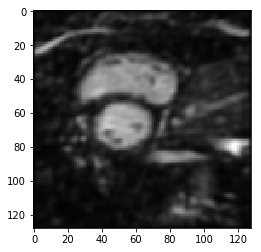

saving epoch {1}
Epoch: 2, Iteration: 1, Loss: 0.003477538703009486, time: 2019-08-03 09:29:23.885699
Epoch: 2, Iteration: 101, Loss: 0.5305629058275372, time: 2019-08-03 09:30:59.710316
150
2019-08-03 09:31:46.654108 Epoch 2, Training loss 0.753886426333338
torch.Size([1, 1, 128, 128, 20])


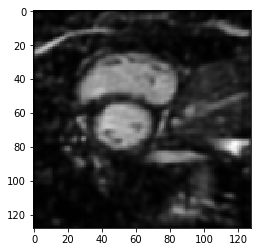

saving epoch {2}
Epoch: 3, Iteration: 1, Loss: 0.0036496412940323353, time: 2019-08-03 09:31:47.800058
Epoch: 3, Iteration: 101, Loss: 0.4307630418334156, time: 2019-08-03 09:33:23.612322
150
2019-08-03 09:34:10.542789 Epoch 3, Training loss 0.627910676645115
torch.Size([1, 1, 128, 128, 20])


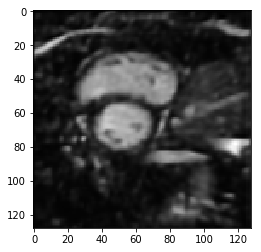

saving epoch {3}
Epoch: 4, Iteration: 1, Loss: 0.0035579227842390537, time: 2019-08-03 09:34:11.692705
Epoch: 4, Iteration: 101, Loss: 0.41266123321838677, time: 2019-08-03 09:35:47.507853
150
2019-08-03 09:36:34.455391 Epoch 4, Training loss 0.588399276137352
torch.Size([1, 1, 128, 128, 20])


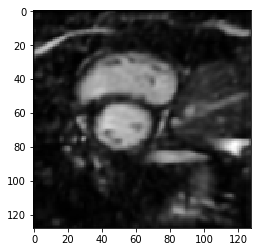

saving epoch {4}
Epoch: 5, Iteration: 1, Loss: 0.003118045162409544, time: 2019-08-03 09:36:35.689020
Epoch: 5, Iteration: 101, Loss: 0.37497851764783263, time: 2019-08-03 09:38:11.492069
150
2019-08-03 09:38:58.443307 Epoch 5, Training loss 0.5573040768504143
torch.Size([1, 1, 128, 128, 20])


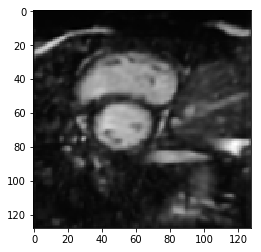

saving epoch {5}
Epoch: 6, Iteration: 1, Loss: 0.0030038896948099136, time: 2019-08-03 09:38:59.590192
Epoch: 6, Iteration: 101, Loss: 0.3813395423348993, time: 2019-08-03 09:40:35.349534
150
2019-08-03 09:41:22.267894 Epoch 6, Training loss 0.5435380456037819
torch.Size([1, 1, 128, 128, 20])


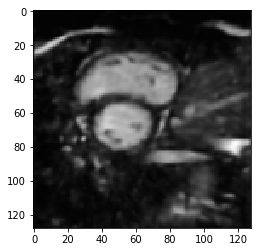

saving epoch {6}
Epoch: 7, Iteration: 1, Loss: 0.0030235217418521643, time: 2019-08-03 09:41:23.423833
Epoch: 7, Iteration: 101, Loss: 0.3610482937656343, time: 2019-08-03 09:42:59.249084
150
2019-08-03 09:43:46.171328 Epoch 7, Training loss 0.5225167777389288
torch.Size([1, 1, 128, 128, 20])


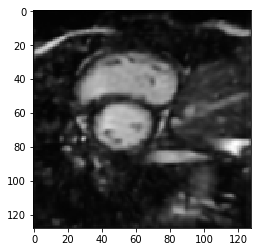

saving epoch {7}
Epoch: 8, Iteration: 1, Loss: 0.002990203443914652, time: 2019-08-03 09:43:47.402912
Epoch: 8, Iteration: 101, Loss: 0.3315218953648582, time: 2019-08-03 09:45:23.171764
150
2019-08-03 09:46:10.114421 Epoch 8, Training loss 0.4753429719712585
torch.Size([1, 1, 128, 128, 20])


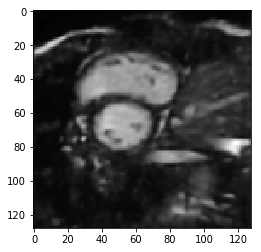

saving epoch {8}
Epoch: 9, Iteration: 1, Loss: 0.00435230229049921, time: 2019-08-03 09:46:11.263153
Epoch: 9, Iteration: 101, Loss: 0.2881697164848447, time: 2019-08-03 09:47:47.034252
150
2019-08-03 09:48:33.995938 Epoch 9, Training loss 0.4219047005753964
torch.Size([1, 1, 128, 128, 20])


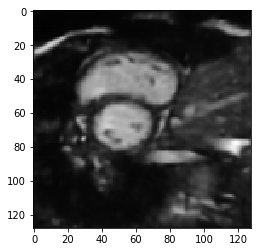

saving epoch {9}
Epoch: 10, Iteration: 1, Loss: 0.002534597646445036, time: 2019-08-03 09:48:35.147524
Epoch: 10, Iteration: 101, Loss: 0.2876121354056522, time: 2019-08-03 09:50:10.927646
150
2019-08-03 09:50:57.846607 Epoch 10, Training loss 0.4202450243756175
torch.Size([1, 1, 128, 128, 20])


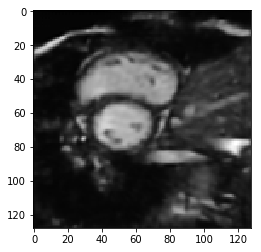

saving epoch {10}
Epoch: 11, Iteration: 1, Loss: 0.00243841833434999, time: 2019-08-03 09:50:58.987401
Epoch: 11, Iteration: 101, Loss: 0.275198902701959, time: 2019-08-03 09:52:34.779001
150
2019-08-03 09:53:21.677540 Epoch 11, Training loss 0.39626736904028803
torch.Size([1, 1, 128, 128, 20])


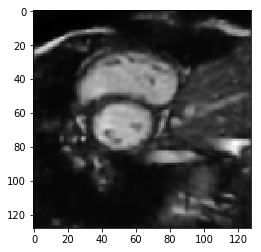

saving epoch {11}
Epoch: 12, Iteration: 1, Loss: 0.00241286214441061, time: 2019-08-03 09:53:22.821411
Epoch: 12, Iteration: 101, Loss: 0.26033142185769975, time: 2019-08-03 09:54:58.575746
150
2019-08-03 09:55:45.505530 Epoch 12, Training loss 0.37973769987002015
torch.Size([1, 1, 128, 128, 20])


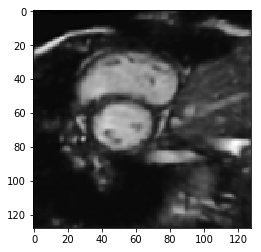

saving epoch {12}
Epoch: 13, Iteration: 1, Loss: 0.002401883015409112, time: 2019-08-03 09:55:46.650319
Epoch: 13, Iteration: 101, Loss: 0.26100031565874815, time: 2019-08-03 09:57:22.425624
150
2019-08-03 09:58:09.345794 Epoch 13, Training loss 0.37782406725455076
torch.Size([1, 1, 128, 128, 20])


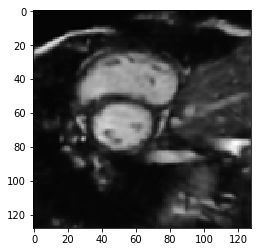

saving epoch {13}
Epoch: 14, Iteration: 1, Loss: 0.002604840090498328, time: 2019-08-03 09:58:10.500528
Epoch: 14, Iteration: 101, Loss: 0.25090260547585785, time: 2019-08-03 09:59:46.293344
150
2019-08-03 10:00:33.242913 Epoch 14, Training loss 0.3639656153973192
torch.Size([1, 1, 128, 128, 20])


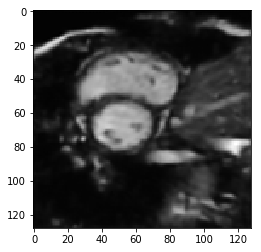

saving epoch {14}
Epoch: 15, Iteration: 1, Loss: 0.002988919848576188, time: 2019-08-03 10:00:34.393511
Epoch: 15, Iteration: 101, Loss: 0.24341734149493277, time: 2019-08-03 10:02:10.175454
150
2019-08-03 10:02:57.119055 Epoch 15, Training loss 0.3517338294768706
torch.Size([1, 1, 128, 128, 20])


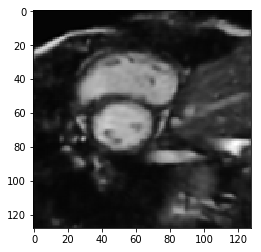

saving epoch {15}
Epoch: 16, Iteration: 1, Loss: 0.0024696337059140205, time: 2019-08-03 10:02:58.276797
Epoch: 16, Iteration: 101, Loss: 0.2418168025324121, time: 2019-08-03 10:04:34.114323
150
2019-08-03 10:05:21.036404 Epoch 16, Training loss 0.3530239132232964
torch.Size([1, 1, 128, 128, 20])


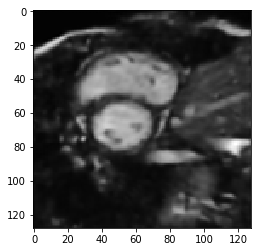

saving epoch {16}
Epoch: 17, Iteration: 1, Loss: 0.0025449979584664106, time: 2019-08-03 10:05:22.183441
Epoch: 17, Iteration: 101, Loss: 0.2536212862469256, time: 2019-08-03 10:06:57.933660
150
2019-08-03 10:07:44.898776 Epoch 17, Training loss 0.36134094919543713
torch.Size([1, 1, 128, 128, 20])


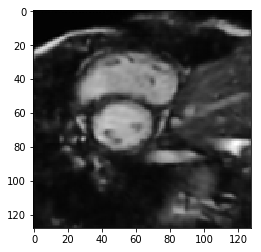

saving epoch {17}
Epoch: 18, Iteration: 1, Loss: 0.001567615196108818, time: 2019-08-03 10:07:46.041346
Epoch: 18, Iteration: 101, Loss: 0.21242737083230168, time: 2019-08-03 10:09:21.841853
150
2019-08-03 10:10:08.781608 Epoch 18, Training loss 0.33363308862317353
torch.Size([1, 1, 128, 128, 20])


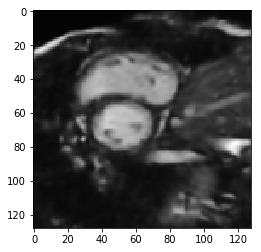

saving epoch {18}
Epoch: 19, Iteration: 1, Loss: 0.003497076453641057, time: 2019-08-03 10:10:09.932191
Epoch: 19, Iteration: 101, Loss: 0.23505940020550042, time: 2019-08-03 10:11:45.746962
150
2019-08-03 10:12:32.676997 Epoch 19, Training loss 0.3319678011466749
torch.Size([1, 1, 128, 128, 20])


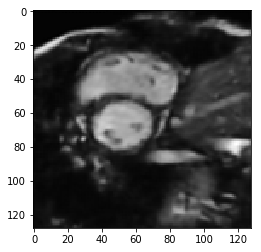

saving epoch {19}
Epoch: 20, Iteration: 1, Loss: 0.0013511471915990114, time: 2019-08-03 10:12:33.822109
Epoch: 20, Iteration: 101, Loss: 0.21942155552096665, time: 2019-08-03 10:14:09.633083
150
2019-08-03 10:14:56.577688 Epoch 20, Training loss 0.3133223467739299
torch.Size([1, 1, 128, 128, 20])


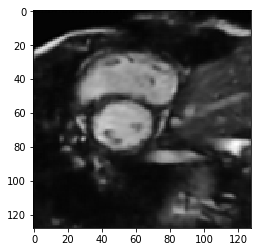

saving epoch {20}
Epoch: 21, Iteration: 1, Loss: 0.0016742274165153503, time: 2019-08-03 10:14:57.727473
Epoch: 21, Iteration: 101, Loss: 0.22205298324115574, time: 2019-08-03 10:16:33.510078
150
2019-08-03 10:17:20.425169 Epoch 21, Training loss 0.3187868254026398
torch.Size([1, 1, 128, 128, 20])


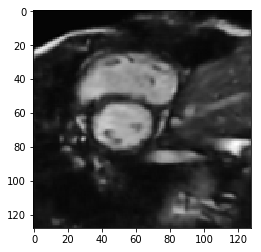

saving epoch {21}
Epoch: 22, Iteration: 1, Loss: 0.00160324911121279, time: 2019-08-03 10:17:21.666691
Epoch: 22, Iteration: 101, Loss: 0.207771425251849, time: 2019-08-03 10:18:57.455347
150
2019-08-03 10:19:44.402054 Epoch 22, Training loss 0.29947648209054023
torch.Size([1, 1, 128, 128, 20])


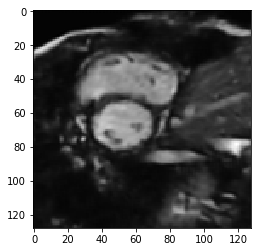

saving epoch {22}
Epoch: 23, Iteration: 1, Loss: 0.0014862418174743652, time: 2019-08-03 10:19:45.545513
Epoch: 23, Iteration: 101, Loss: 0.20840071281418204, time: 2019-08-03 10:21:21.317382
150
2019-08-03 10:22:08.236613 Epoch 23, Training loss 0.309171148808673
torch.Size([1, 1, 128, 128, 20])


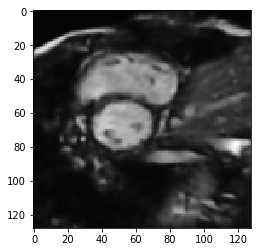

saving epoch {23}
Epoch: 24, Iteration: 1, Loss: 0.0028486286755651236, time: 2019-08-03 10:22:09.380659
Epoch: 24, Iteration: 101, Loss: 0.2071409928612411, time: 2019-08-03 10:23:45.141385
150
2019-08-03 10:24:32.082921 Epoch 24, Training loss 0.29854713776148856
torch.Size([1, 1, 128, 128, 20])


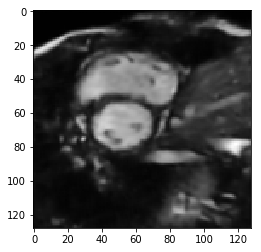

saving epoch {24}
Epoch: 25, Iteration: 1, Loss: 0.0018379244720563293, time: 2019-08-03 10:24:33.227305
Epoch: 25, Iteration: 101, Loss: 0.19104853738099337, time: 2019-08-03 10:26:09.005912
150
2019-08-03 10:26:55.929315 Epoch 25, Training loss 0.2960719618713483
torch.Size([1, 1, 128, 128, 20])


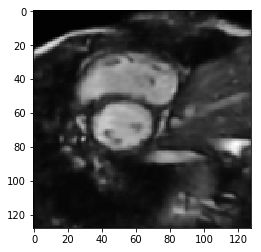

saving epoch {25}
Epoch: 26, Iteration: 1, Loss: 0.002569877775385976, time: 2019-08-03 10:26:57.067417
Epoch: 26, Iteration: 101, Loss: 0.18659999803639948, time: 2019-08-03 10:28:32.834751
150
2019-08-03 10:29:19.739785 Epoch 26, Training loss 0.2919663585489616
torch.Size([1, 1, 128, 128, 20])


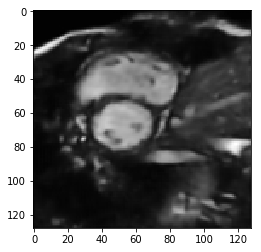

saving epoch {26}
Epoch: 27, Iteration: 1, Loss: 0.0013909655390307307, time: 2019-08-03 10:29:20.891003
Epoch: 27, Iteration: 101, Loss: 0.19539243821054697, time: 2019-08-03 10:30:56.661674
150
2019-08-03 10:31:43.586626 Epoch 27, Training loss 0.28560524445492774
torch.Size([1, 1, 128, 128, 20])


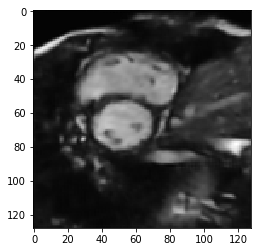

saving epoch {27}
Epoch: 28, Iteration: 1, Loss: 0.0017167448531836271, time: 2019-08-03 10:31:44.734836
Epoch: 28, Iteration: 101, Loss: 0.18892626627348363, time: 2019-08-03 10:33:20.496735
150
2019-08-03 10:34:07.406024 Epoch 28, Training loss 0.27963933895807713
torch.Size([1, 1, 128, 128, 20])


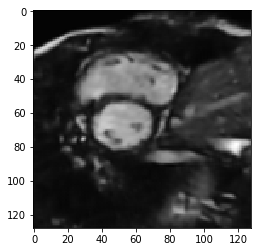

saving epoch {28}
Epoch: 29, Iteration: 1, Loss: 0.0018709746655076742, time: 2019-08-03 10:34:08.546526
Epoch: 29, Iteration: 101, Loss: 0.1869959494797513, time: 2019-08-03 10:35:44.294287
150
2019-08-03 10:36:31.181036 Epoch 29, Training loss 0.27538240153808147
torch.Size([1, 1, 128, 128, 20])


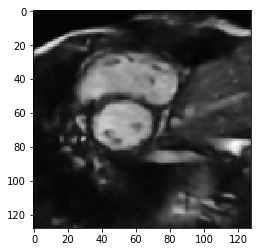

saving epoch {29}
Epoch: 30, Iteration: 1, Loss: 0.0021402116399258375, time: 2019-08-03 10:36:32.324742
Epoch: 30, Iteration: 101, Loss: 0.1821313442196697, time: 2019-08-03 10:38:08.094574
150
2019-08-03 10:38:55.026652 Epoch 30, Training loss 0.2662762952968478
torch.Size([1, 1, 128, 128, 20])


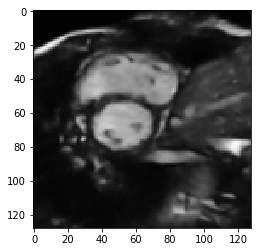

saving epoch {30}
Epoch: 31, Iteration: 1, Loss: 0.0013434872962534428, time: 2019-08-03 10:38:56.177012
Epoch: 31, Iteration: 101, Loss: 0.1767519429558888, time: 2019-08-03 10:40:31.926866
150
2019-08-03 10:41:18.849735 Epoch 31, Training loss 0.25778757384978235
torch.Size([1, 1, 128, 128, 20])


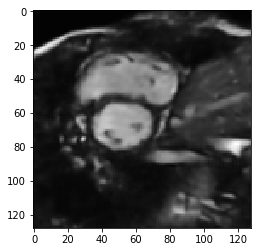

saving epoch {31}
Epoch: 32, Iteration: 1, Loss: 0.0018758394289761782, time: 2019-08-03 10:41:19.993873
Epoch: 32, Iteration: 101, Loss: 0.1794206522172317, time: 2019-08-03 10:42:55.749774
150
2019-08-03 10:43:42.701253 Epoch 32, Training loss 0.2571185000706464
torch.Size([1, 1, 128, 128, 20])


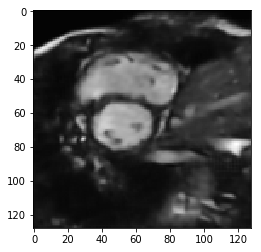

saving epoch {32}
Epoch: 33, Iteration: 1, Loss: 0.0017104670405387878, time: 2019-08-03 10:43:43.847148
Epoch: 33, Iteration: 101, Loss: 0.16295063053257763, time: 2019-08-03 10:45:19.615887
150
2019-08-03 10:46:06.514614 Epoch 33, Training loss 0.24363638169597834
torch.Size([1, 1, 128, 128, 20])


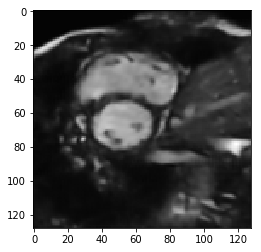

saving epoch {33}
Epoch: 34, Iteration: 1, Loss: 0.002884666668251157, time: 2019-08-03 10:46:07.657125
Epoch: 34, Iteration: 101, Loss: 0.17106939281802624, time: 2019-08-03 10:47:43.434098
150
2019-08-03 10:48:30.324418 Epoch 34, Training loss 0.2579213975695893
torch.Size([1, 1, 128, 128, 20])


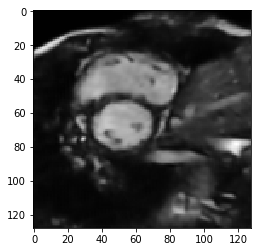

saving epoch {34}
Epoch: 35, Iteration: 1, Loss: 0.0014495026553049684, time: 2019-08-03 10:48:31.502058
Epoch: 35, Iteration: 101, Loss: 0.1531533331144601, time: 2019-08-03 10:50:07.262140
150
2019-08-03 10:50:54.194679 Epoch 35, Training loss 0.2357343975454569
torch.Size([1, 1, 128, 128, 20])


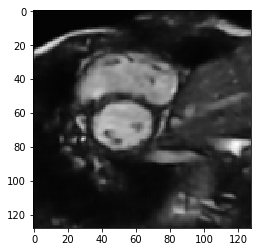

saving epoch {35}
Epoch: 36, Iteration: 1, Loss: 0.0012522370088845491, time: 2019-08-03 10:50:55.340438
Epoch: 36, Iteration: 101, Loss: 0.1581511899130419, time: 2019-08-03 10:52:31.087477
150
2019-08-03 10:53:18.022624 Epoch 36, Training loss 0.23575482243904844
torch.Size([1, 1, 128, 128, 20])


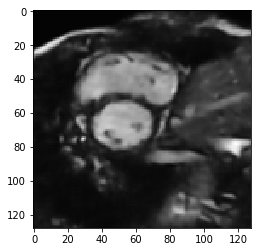

saving epoch {36}
Epoch: 37, Iteration: 1, Loss: 0.001341970288194716, time: 2019-08-03 10:53:19.163832
Epoch: 37, Iteration: 101, Loss: 0.15660349885001779, time: 2019-08-03 10:54:54.922032
150
2019-08-03 10:55:41.851587 Epoch 37, Training loss 0.22869597491808236
torch.Size([1, 1, 128, 128, 20])


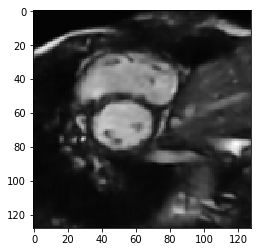

saving epoch {37}
Epoch: 38, Iteration: 1, Loss: 0.0017937213415279984, time: 2019-08-03 10:55:42.991936
Epoch: 38, Iteration: 101, Loss: 0.14441424160031602, time: 2019-08-03 10:57:18.722262
150
2019-08-03 10:58:05.644701 Epoch 38, Training loss 0.21604103891877457
torch.Size([1, 1, 128, 128, 20])


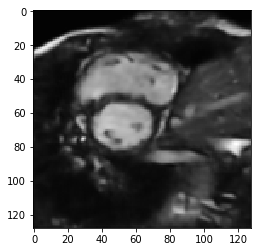

saving epoch {38}
Epoch: 39, Iteration: 1, Loss: 0.001258378499187529, time: 2019-08-03 10:58:06.882498
Epoch: 39, Iteration: 101, Loss: 0.14042173587949947, time: 2019-08-03 10:59:42.624550
150
2019-08-03 11:00:29.544593 Epoch 39, Training loss 0.21607150783529505
torch.Size([1, 1, 128, 128, 20])


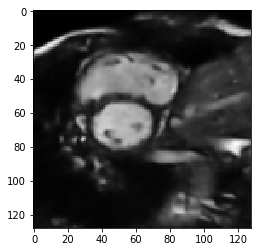

saving epoch {39}
Epoch: 40, Iteration: 1, Loss: 0.0022701863199472427, time: 2019-08-03 11:00:30.701733
Epoch: 40, Iteration: 101, Loss: 0.15225217957049608, time: 2019-08-03 11:02:06.480411
150
2019-08-03 11:02:53.385179 Epoch 40, Training loss 0.22281729942187667
torch.Size([1, 1, 128, 128, 20])


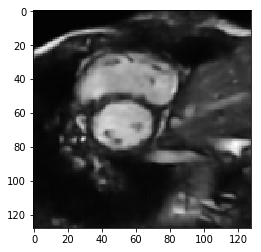

saving epoch {40}
Epoch: 41, Iteration: 1, Loss: 0.0021452673245221376, time: 2019-08-03 11:02:54.533979
Epoch: 41, Iteration: 101, Loss: 0.14005578157957643, time: 2019-08-03 11:04:30.287601
150
2019-08-03 11:05:17.220992 Epoch 41, Training loss 0.20100660721072927
torch.Size([1, 1, 128, 128, 20])


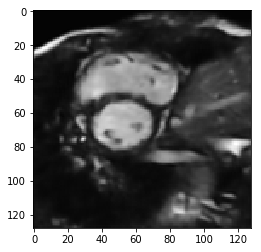

saving epoch {41}
Epoch: 42, Iteration: 1, Loss: 0.0015645790845155716, time: 2019-08-03 11:05:18.363980
Epoch: 42, Iteration: 101, Loss: 0.13052632502513006, time: 2019-08-03 11:06:54.152268
150
2019-08-03 11:07:41.080956 Epoch 42, Training loss 0.1947420570650138
torch.Size([1, 1, 128, 128, 20])


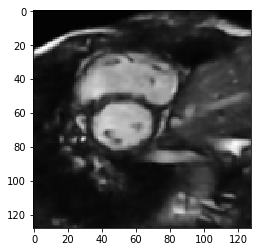

saving epoch {42}
Epoch: 43, Iteration: 1, Loss: 0.0016332051018252969, time: 2019-08-03 11:07:42.223753
Epoch: 43, Iteration: 101, Loss: 0.12852261262014508, time: 2019-08-03 11:09:17.955826
150
2019-08-03 11:10:04.883555 Epoch 43, Training loss 0.19189627235755324
torch.Size([1, 1, 128, 128, 20])


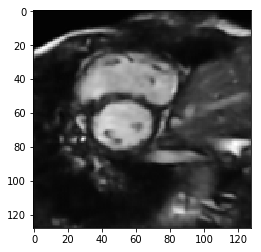

saving epoch {43}
Epoch: 44, Iteration: 1, Loss: 0.001360249938443303, time: 2019-08-03 11:10:06.031895
Epoch: 44, Iteration: 101, Loss: 0.12752876040758565, time: 2019-08-03 11:11:41.843914
150
2019-08-03 11:12:28.738188 Epoch 44, Training loss 0.1848868376109749
torch.Size([1, 1, 128, 128, 20])


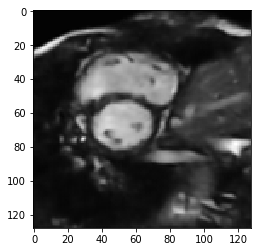

saving epoch {44}
Epoch: 45, Iteration: 1, Loss: 0.0012507822830229998, time: 2019-08-03 11:12:29.878071
Epoch: 45, Iteration: 101, Loss: 0.1203612299868837, time: 2019-08-03 11:14:05.650032
150
2019-08-03 11:14:52.589798 Epoch 45, Training loss 0.1884804667206481
torch.Size([1, 1, 128, 128, 20])


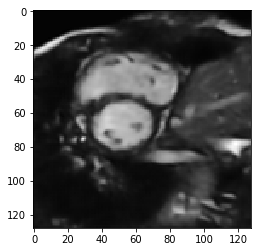

saving epoch {45}
Epoch: 46, Iteration: 1, Loss: 0.0022949979174882174, time: 2019-08-03 11:14:53.730963
Epoch: 46, Iteration: 101, Loss: 0.12388552498305216, time: 2019-08-03 11:16:29.497451
150
2019-08-03 11:17:16.431830 Epoch 46, Training loss 0.17964694614056498
torch.Size([1, 1, 128, 128, 20])


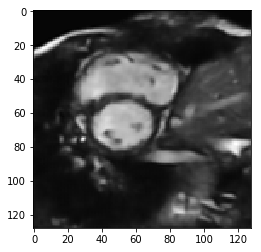

saving epoch {46}
Epoch: 47, Iteration: 1, Loss: 0.0011010471498593688, time: 2019-08-03 11:17:17.575230
Epoch: 47, Iteration: 101, Loss: 0.1133357462240383, time: 2019-08-03 11:18:53.338400
150
2019-08-03 11:19:40.273655 Epoch 47, Training loss 0.17038357019191608
torch.Size([1, 1, 128, 128, 20])


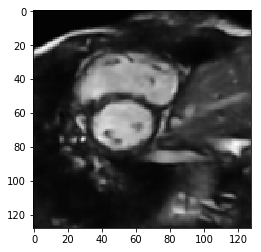

saving epoch {47}
Epoch: 48, Iteration: 1, Loss: 0.0010420393664389849, time: 2019-08-03 11:19:41.421897
Epoch: 48, Iteration: 101, Loss: 0.11869167088298127, time: 2019-08-03 11:21:17.216550
150
2019-08-03 11:22:04.149128 Epoch 48, Training loss 0.17489838652545586
torch.Size([1, 1, 128, 128, 20])


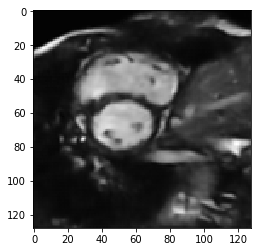

saving epoch {48}
Epoch: 49, Iteration: 1, Loss: 0.001345259603112936, time: 2019-08-03 11:22:05.298923
Epoch: 49, Iteration: 101, Loss: 0.1044948817580007, time: 2019-08-03 11:23:41.081730
150
2019-08-03 11:24:28.029144 Epoch 49, Training loss 0.1587598019395955
torch.Size([1, 1, 128, 128, 20])


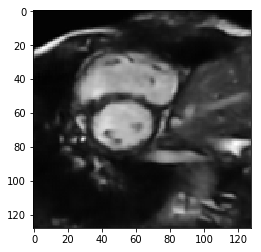

saving epoch {49}
Epoch: 50, Iteration: 1, Loss: 0.000807909294962883, time: 2019-08-03 11:24:29.181426
Epoch: 50, Iteration: 101, Loss: 0.09957237541675568, time: 2019-08-03 11:26:04.926915
150
2019-08-03 11:26:51.855396 Epoch 50, Training loss 0.14975140616297722
torch.Size([1, 1, 128, 128, 20])


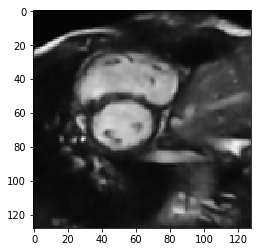

saving epoch {50}
Epoch: 51, Iteration: 1, Loss: 0.000969059590715915, time: 2019-08-03 11:26:52.997281
Epoch: 51, Iteration: 101, Loss: 0.0977090218802914, time: 2019-08-03 11:28:28.762406
150
2019-08-03 11:29:15.691555 Epoch 51, Training loss 0.1528815464116633
torch.Size([1, 1, 128, 128, 20])


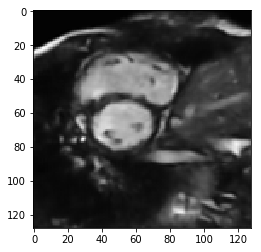

saving epoch {51}
Epoch: 52, Iteration: 1, Loss: 0.0013331379741430283, time: 2019-08-03 11:29:16.837683
Epoch: 52, Iteration: 101, Loss: 0.10919949866365641, time: 2019-08-03 11:30:52.597582
150
2019-08-03 11:31:39.579574 Epoch 52, Training loss 0.15717887569917366
torch.Size([1, 1, 128, 128, 20])


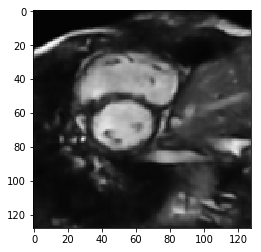

saving epoch {52}
Epoch: 53, Iteration: 1, Loss: 0.0009655941976234317, time: 2019-08-03 11:31:40.724567
Epoch: 53, Iteration: 101, Loss: 0.09783603361574933, time: 2019-08-03 11:33:16.493269
150
2019-08-03 11:34:03.413339 Epoch 53, Training loss 0.15225866122636944
torch.Size([1, 1, 128, 128, 20])


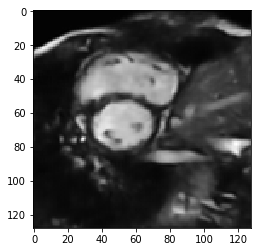

saving epoch {53}
Epoch: 54, Iteration: 1, Loss: 0.0010943060042336583, time: 2019-08-03 11:34:04.568504
Epoch: 54, Iteration: 101, Loss: 0.10305298917228356, time: 2019-08-03 11:35:40.314152
150
2019-08-03 11:36:27.240510 Epoch 54, Training loss 0.1548733974341303
torch.Size([1, 1, 128, 128, 20])


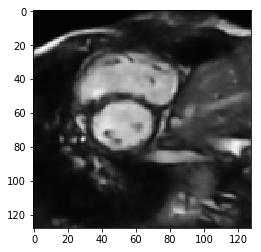

saving epoch {54}
Epoch: 55, Iteration: 1, Loss: 0.0009066349011845887, time: 2019-08-03 11:36:28.384409
Epoch: 55, Iteration: 101, Loss: 0.09213839785661548, time: 2019-08-03 11:38:04.135020
150
2019-08-03 11:38:51.050035 Epoch 55, Training loss 0.13663356413599104
torch.Size([1, 1, 128, 128, 20])


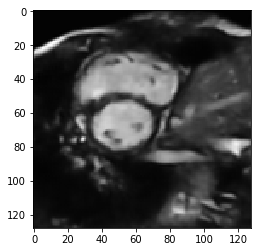

saving epoch {55}
Epoch: 56, Iteration: 1, Loss: 0.0009776364313438535, time: 2019-08-03 11:38:52.278523
Epoch: 56, Iteration: 101, Loss: 0.09905560908373445, time: 2019-08-03 11:40:28.026195
150
2019-08-03 11:41:14.955038 Epoch 56, Training loss 0.14360794390086085
torch.Size([1, 1, 128, 128, 20])


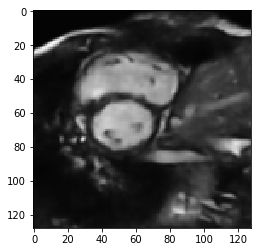

saving epoch {56}
Epoch: 57, Iteration: 1, Loss: 0.0008585200412198901, time: 2019-08-03 11:41:16.095333
Epoch: 57, Iteration: 101, Loss: 0.08809836400905624, time: 2019-08-03 11:42:51.898505
150
2019-08-03 11:43:38.852102 Epoch 57, Training loss 0.13265541451983154
torch.Size([1, 1, 128, 128, 20])


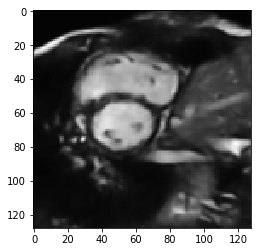

saving epoch {57}
Epoch: 58, Iteration: 1, Loss: 0.0009834797820076346, time: 2019-08-03 11:43:39.998475
Epoch: 58, Iteration: 101, Loss: 0.08859941130504012, time: 2019-08-03 11:45:15.770509
150
2019-08-03 11:46:02.711043 Epoch 58, Training loss 0.13458736141910776
torch.Size([1, 1, 128, 128, 20])


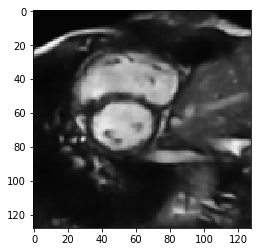

saving epoch {58}
Epoch: 59, Iteration: 1, Loss: 0.0009153609280474484, time: 2019-08-03 11:46:03.860400
Epoch: 59, Iteration: 101, Loss: 0.08491010562283918, time: 2019-08-03 11:47:39.676398
150
2019-08-03 11:48:26.596088 Epoch 59, Training loss 0.12674257170874625
torch.Size([1, 1, 128, 128, 20])


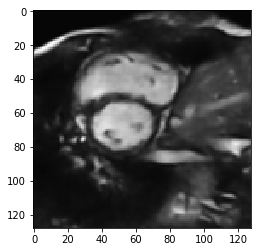

saving epoch {59}
Epoch: 60, Iteration: 1, Loss: 0.0007814440177753568, time: 2019-08-03 11:48:27.739401
Epoch: 60, Iteration: 101, Loss: 0.08513970230706036, time: 2019-08-03 11:50:03.505240
150
2019-08-03 11:50:50.456054 Epoch 60, Training loss 0.12757613143185154
torch.Size([1, 1, 128, 128, 20])


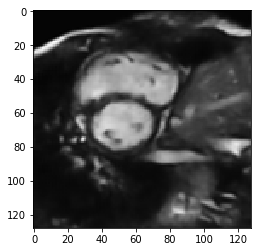

saving epoch {60}
Epoch: 61, Iteration: 1, Loss: 0.0007207324379123747, time: 2019-08-03 11:50:51.600970
Epoch: 61, Iteration: 101, Loss: 0.08633654291043058, time: 2019-08-03 11:52:27.339630
150
2019-08-03 11:53:14.277630 Epoch 61, Training loss 0.1272473286371678
torch.Size([1, 1, 128, 128, 20])


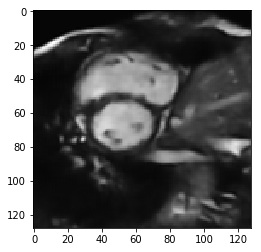

saving epoch {61}
Epoch: 62, Iteration: 1, Loss: 0.0010123115498572588, time: 2019-08-03 11:53:15.424737
Epoch: 62, Iteration: 101, Loss: 0.0835374923190102, time: 2019-08-03 11:54:51.177940
150
2019-08-03 11:55:38.108343 Epoch 62, Training loss 0.12342015031026676
torch.Size([1, 1, 128, 128, 20])


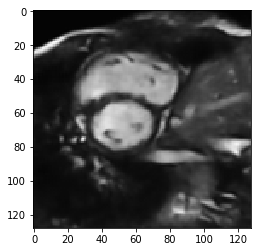

saving epoch {62}
Epoch: 63, Iteration: 1, Loss: 0.0007028456893749535, time: 2019-08-03 11:55:39.250698
Epoch: 63, Iteration: 101, Loss: 0.07797078782459721, time: 2019-08-03 11:57:15.030607
150
2019-08-03 11:58:01.970668 Epoch 63, Training loss 0.11682745220605284
torch.Size([1, 1, 128, 128, 20])


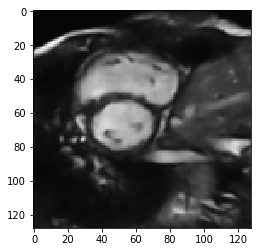

saving epoch {63}
Epoch: 64, Iteration: 1, Loss: 0.0007582794642075896, time: 2019-08-03 11:58:03.114180
Epoch: 64, Iteration: 101, Loss: 0.07638967654202133, time: 2019-08-03 11:59:38.864003
150
2019-08-03 12:00:25.798897 Epoch 64, Training loss 0.1170295017072931
torch.Size([1, 1, 128, 128, 20])


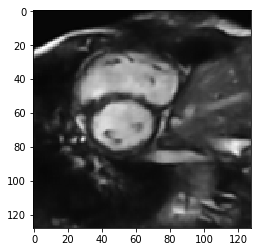

saving epoch {64}
Epoch: 65, Iteration: 1, Loss: 0.0007445443188771605, time: 2019-08-03 12:00:26.942636
Epoch: 65, Iteration: 101, Loss: 0.08060779748484492, time: 2019-08-03 12:02:02.712302
150
2019-08-03 12:02:49.649191 Epoch 65, Training loss 0.12660441821208224
torch.Size([1, 1, 128, 128, 20])


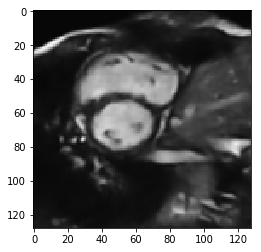

saving epoch {65}
Epoch: 66, Iteration: 1, Loss: 0.0008910780888982117, time: 2019-08-03 12:02:50.796037
Epoch: 66, Iteration: 101, Loss: 0.09464536502491683, time: 2019-08-03 12:04:26.580249
150
2019-08-03 12:05:13.507996 Epoch 66, Training loss 0.13430278928717598
torch.Size([1, 1, 128, 128, 20])


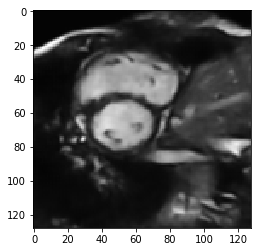

saving epoch {66}
Epoch: 67, Iteration: 1, Loss: 0.000689608626998961, time: 2019-08-03 12:05:14.649561
Epoch: 67, Iteration: 101, Loss: 0.0782324307365343, time: 2019-08-03 12:06:50.386854
150
2019-08-03 12:07:37.349048 Epoch 67, Training loss 0.11601122340653092
torch.Size([1, 1, 128, 128, 20])


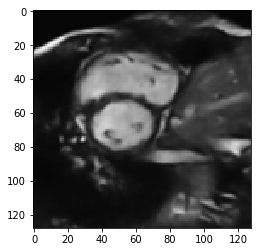

saving epoch {67}
Epoch: 68, Iteration: 1, Loss: 0.0009747905423864722, time: 2019-08-03 12:07:38.507882
Epoch: 68, Iteration: 101, Loss: 0.08012236253125593, time: 2019-08-03 12:09:14.268204
150
2019-08-03 12:10:01.187145 Epoch 68, Training loss 0.12008917360799387
torch.Size([1, 1, 128, 128, 20])


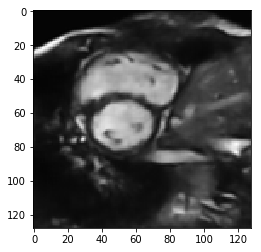

saving epoch {68}
Epoch: 69, Iteration: 1, Loss: 0.0007731948280707002, time: 2019-08-03 12:10:02.334298
Epoch: 69, Iteration: 101, Loss: 0.07685800507897511, time: 2019-08-03 12:11:38.065466
150
2019-08-03 12:12:24.989919 Epoch 69, Training loss 0.11500455968780443
torch.Size([1, 1, 128, 128, 20])


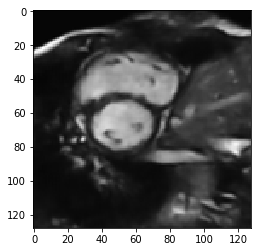

saving epoch {69}
Epoch: 70, Iteration: 1, Loss: 0.0006642788066528738, time: 2019-08-03 12:12:26.133344
Epoch: 70, Iteration: 101, Loss: 0.08163233730010688, time: 2019-08-03 12:14:01.919570
150
2019-08-03 12:14:48.844124 Epoch 70, Training loss 0.1208758947905153
torch.Size([1, 1, 128, 128, 20])


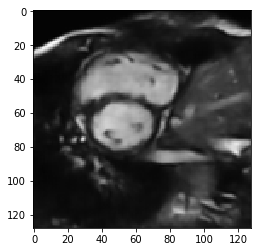

saving epoch {70}
Epoch: 71, Iteration: 1, Loss: 0.0006788579048588872, time: 2019-08-03 12:14:49.991716
Epoch: 71, Iteration: 101, Loss: 0.07369396497961134, time: 2019-08-03 12:16:25.737665
150
2019-08-03 12:17:12.644679 Epoch 71, Training loss 0.10982426581904292
torch.Size([1, 1, 128, 128, 20])


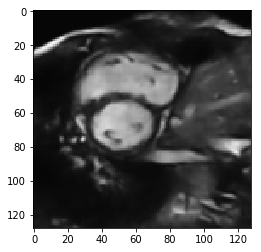

saving epoch {71}
Epoch: 72, Iteration: 1, Loss: 0.0005986506002955139, time: 2019-08-03 12:17:13.791691
Epoch: 72, Iteration: 101, Loss: 0.07362634351011366, time: 2019-08-03 12:18:49.559108
150
2019-08-03 12:19:36.465024 Epoch 72, Training loss 0.1082225987338461
torch.Size([1, 1, 128, 128, 20])


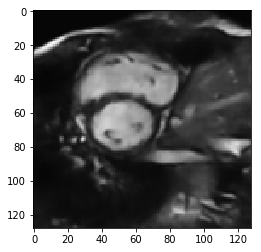

saving epoch {72}
Epoch: 73, Iteration: 1, Loss: 0.0005388439749367535, time: 2019-08-03 12:19:37.703653
Epoch: 73, Iteration: 101, Loss: 0.07308380136964843, time: 2019-08-03 12:21:13.465924
150
2019-08-03 12:22:00.389841 Epoch 73, Training loss 0.10991725925123319
torch.Size([1, 1, 128, 128, 20])


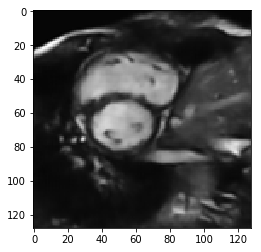

saving epoch {73}
Epoch: 74, Iteration: 1, Loss: 0.000764563912525773, time: 2019-08-03 12:22:01.534514
Epoch: 74, Iteration: 101, Loss: 0.0745746255852282, time: 2019-08-03 12:23:37.303654
150
2019-08-03 12:24:24.226778 Epoch 74, Training loss 0.1138970993924886
torch.Size([1, 1, 128, 128, 20])


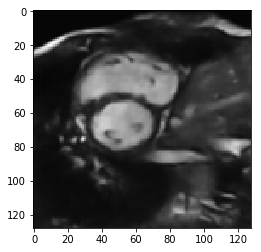

saving epoch {74}
Epoch: 75, Iteration: 1, Loss: 0.0008462715777568519, time: 2019-08-03 12:24:25.375194
Epoch: 75, Iteration: 101, Loss: 0.07716897095087916, time: 2019-08-03 12:26:01.139199
150
2019-08-03 12:26:48.067248 Epoch 75, Training loss 0.11474651569733396
torch.Size([1, 1, 128, 128, 20])


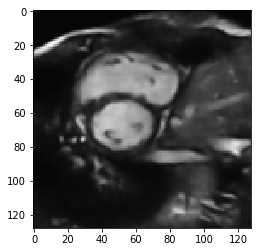

saving epoch {75}
Epoch: 76, Iteration: 1, Loss: 0.0006339221145026386, time: 2019-08-03 12:26:49.212102
Epoch: 76, Iteration: 101, Loss: 0.07255562400678173, time: 2019-08-03 12:28:24.963475
150
2019-08-03 12:29:11.895114 Epoch 76, Training loss 0.10660830058623105
torch.Size([1, 1, 128, 128, 20])


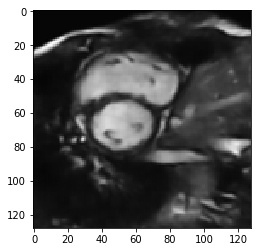

saving epoch {76}
Epoch: 77, Iteration: 1, Loss: 0.0006247538840398192, time: 2019-08-03 12:29:13.042019
Epoch: 77, Iteration: 101, Loss: 0.07069389941170812, time: 2019-08-03 12:30:48.825064
150
2019-08-03 12:31:35.746215 Epoch 77, Training loss 0.10437694023130462
torch.Size([1, 1, 128, 128, 20])


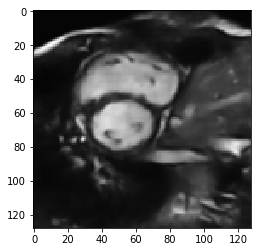

saving epoch {77}
Epoch: 78, Iteration: 1, Loss: 0.0006820933194831014, time: 2019-08-03 12:31:36.889175
Epoch: 78, Iteration: 101, Loss: 0.0685061719850637, time: 2019-08-03 12:33:12.657101
150
2019-08-03 12:33:59.580048 Epoch 78, Training loss 0.10171178908785805
torch.Size([1, 1, 128, 128, 20])


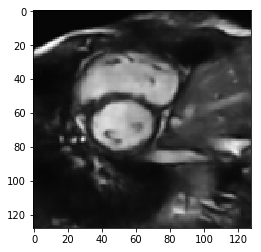

saving epoch {78}
Epoch: 79, Iteration: 1, Loss: 0.0005900025134906173, time: 2019-08-03 12:34:00.738956
Epoch: 79, Iteration: 101, Loss: 0.06806915177730843, time: 2019-08-03 12:35:36.544921
150
2019-08-03 12:36:23.512056 Epoch 79, Training loss 0.10158841055817902
torch.Size([1, 1, 128, 128, 20])


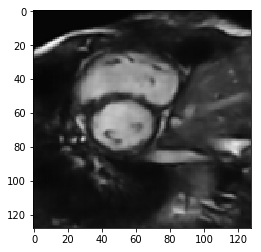

saving epoch {79}
Epoch: 80, Iteration: 1, Loss: 0.0007776581915095448, time: 2019-08-03 12:36:24.660311
Epoch: 80, Iteration: 101, Loss: 0.0690141647355631, time: 2019-08-03 12:38:00.466572
150
2019-08-03 12:38:47.413557 Epoch 80, Training loss 0.10315146914217621
torch.Size([1, 1, 128, 128, 20])


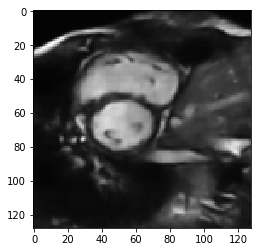

saving epoch {80}
Epoch: 81, Iteration: 1, Loss: 0.0006497332942672074, time: 2019-08-03 12:38:48.573288
Epoch: 81, Iteration: 101, Loss: 0.07170059939380735, time: 2019-08-03 12:40:24.364679
150
2019-08-03 12:41:11.313190 Epoch 81, Training loss 0.1074806951219216
torch.Size([1, 1, 128, 128, 20])


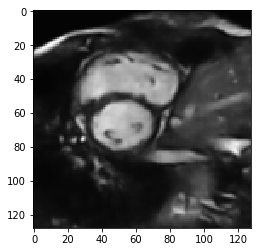

saving epoch {81}
Epoch: 82, Iteration: 1, Loss: 0.0007798225851729512, time: 2019-08-03 12:41:12.464275
Epoch: 82, Iteration: 101, Loss: 0.07451811735518277, time: 2019-08-03 12:42:48.236181
150
2019-08-03 12:43:35.156449 Epoch 82, Training loss 0.10811164107872173
torch.Size([1, 1, 128, 128, 20])


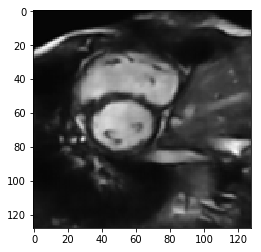

saving epoch {82}
Epoch: 83, Iteration: 1, Loss: 0.000583593500778079, time: 2019-08-03 12:43:36.308286
Epoch: 83, Iteration: 101, Loss: 0.06832332513295114, time: 2019-08-03 12:45:12.086605
150
2019-08-03 12:45:59.042080 Epoch 83, Training loss 0.09978020054404624
torch.Size([1, 1, 128, 128, 20])


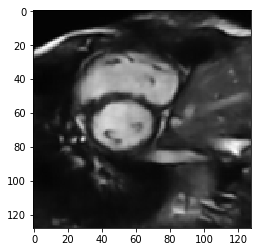

saving epoch {83}
Epoch: 84, Iteration: 1, Loss: 0.0006308975862339139, time: 2019-08-03 12:46:00.188768
Epoch: 84, Iteration: 101, Loss: 0.06669846875593066, time: 2019-08-03 12:47:35.965058
150
2019-08-03 12:48:22.902331 Epoch 84, Training loss 0.09904245636425912
torch.Size([1, 1, 128, 128, 20])


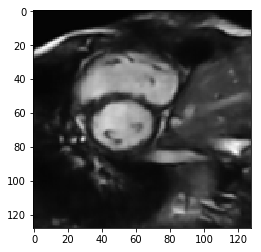

saving epoch {84}
Epoch: 85, Iteration: 1, Loss: 0.0006799536640755832, time: 2019-08-03 12:48:24.053352
Epoch: 85, Iteration: 101, Loss: 0.0651935754576698, time: 2019-08-03 12:49:59.805944
150
2019-08-03 12:50:46.731963 Epoch 85, Training loss 0.09707009454723448
torch.Size([1, 1, 128, 128, 20])


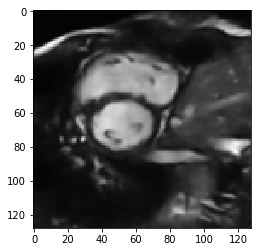

saving epoch {85}
Epoch: 86, Iteration: 1, Loss: 0.0006468361243605614, time: 2019-08-03 12:50:47.876426
Epoch: 86, Iteration: 101, Loss: 0.06775522721000016, time: 2019-08-03 12:52:23.641529
150
2019-08-03 12:53:10.554851 Epoch 86, Training loss 0.10167710651876405
torch.Size([1, 1, 128, 128, 20])


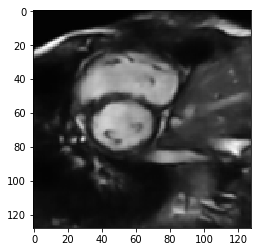

saving epoch {86}
Epoch: 87, Iteration: 1, Loss: 0.0005787582485936582, time: 2019-08-03 12:53:11.708284
Epoch: 87, Iteration: 101, Loss: 0.0665092684503179, time: 2019-08-03 12:54:47.477597
150
2019-08-03 12:55:34.420358 Epoch 87, Training loss 0.1015725109318737
torch.Size([1, 1, 128, 128, 20])


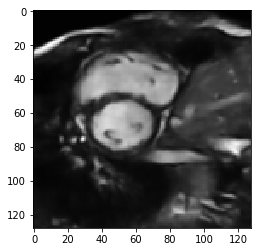

saving epoch {87}
Epoch: 88, Iteration: 1, Loss: 0.000596950703766197, time: 2019-08-03 12:55:35.574231
Epoch: 88, Iteration: 101, Loss: 0.06572406290797517, time: 2019-08-03 12:57:11.354451
150
2019-08-03 12:57:58.275488 Epoch 88, Training loss 0.10103520343545824
torch.Size([1, 1, 128, 128, 20])


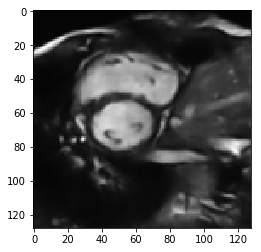

saving epoch {88}
Epoch: 89, Iteration: 1, Loss: 0.0006508546648547053, time: 2019-08-03 12:57:59.431821
Epoch: 89, Iteration: 101, Loss: 0.07173041286296211, time: 2019-08-03 12:59:35.196931
150
2019-08-03 13:00:22.141903 Epoch 89, Training loss 0.10723245344706811
torch.Size([1, 1, 128, 128, 20])


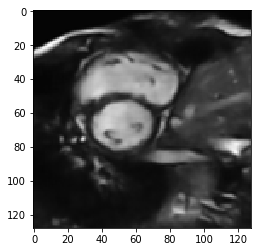

saving epoch {89}
Epoch: 90, Iteration: 1, Loss: 0.0008328810217790306, time: 2019-08-03 13:00:23.385155
Epoch: 90, Iteration: 101, Loss: 0.06658852132386528, time: 2019-08-03 13:01:59.209255
150
2019-08-03 13:02:46.132981 Epoch 90, Training loss 0.10087983499397524
torch.Size([1, 1, 128, 128, 20])


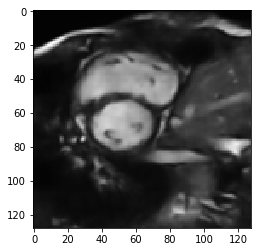

saving epoch {90}
Epoch: 91, Iteration: 1, Loss: 0.000671571702696383, time: 2019-08-03 13:02:47.271421
Epoch: 91, Iteration: 101, Loss: 0.0673498705145903, time: 2019-08-03 13:04:23.020387
150
2019-08-03 13:05:09.976854 Epoch 91, Training loss 0.09902905812487006
torch.Size([1, 1, 128, 128, 20])


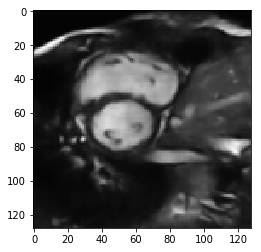

saving epoch {91}
Epoch: 92, Iteration: 1, Loss: 0.0006861629080958664, time: 2019-08-03 13:05:11.126019
Epoch: 92, Iteration: 101, Loss: 0.06383555894717574, time: 2019-08-03 13:06:46.939002
150
2019-08-03 13:07:33.891964 Epoch 92, Training loss 0.09908371293568052
torch.Size([1, 1, 128, 128, 20])


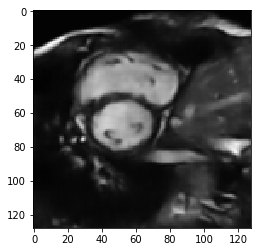

saving epoch {92}
Epoch: 93, Iteration: 1, Loss: 0.0007176852086558938, time: 2019-08-03 13:07:35.046935
Epoch: 93, Iteration: 101, Loss: 0.0700636132969521, time: 2019-08-03 13:09:10.811151
150
2019-08-03 13:09:57.745474 Epoch 93, Training loss 0.1026282430102583
torch.Size([1, 1, 128, 128, 20])


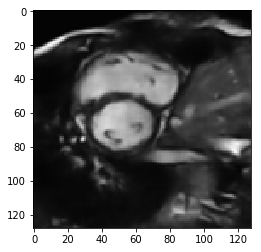

saving epoch {93}
Epoch: 94, Iteration: 1, Loss: 0.0004901363863609731, time: 2019-08-03 13:09:58.896770
Epoch: 94, Iteration: 101, Loss: 0.06405194531544112, time: 2019-08-03 13:11:34.672544
150
2019-08-03 13:12:21.608783 Epoch 94, Training loss 0.09635874765808694
torch.Size([1, 1, 128, 128, 20])


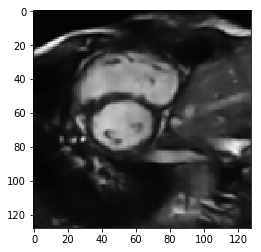

saving epoch {94}
Epoch: 95, Iteration: 1, Loss: 0.000639878329820931, time: 2019-08-03 13:12:22.762638
Epoch: 95, Iteration: 101, Loss: 0.061554248590255156, time: 2019-08-03 13:13:58.530987
150
2019-08-03 13:14:45.442809 Epoch 95, Training loss 0.09196259450982325
torch.Size([1, 1, 128, 128, 20])


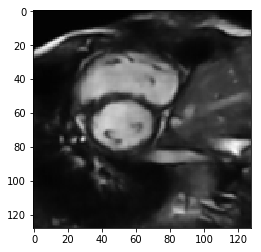

saving epoch {95}
Epoch: 96, Iteration: 1, Loss: 0.0005733432481065392, time: 2019-08-03 13:14:46.593672
Epoch: 96, Iteration: 101, Loss: 0.060058254457544535, time: 2019-08-03 13:16:22.406602
150
2019-08-03 13:17:09.331451 Epoch 96, Training loss 0.09116115106735379
torch.Size([1, 1, 128, 128, 20])


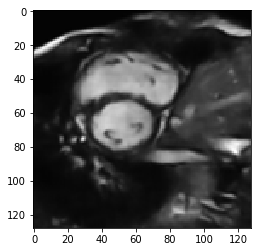

saving epoch {96}
Epoch: 97, Iteration: 1, Loss: 0.00047333521069958806, time: 2019-08-03 13:17:10.478972
Epoch: 97, Iteration: 101, Loss: 0.061922919616336, time: 2019-08-03 13:18:46.275674
150
2019-08-03 13:19:33.200822 Epoch 97, Training loss 0.09265442760079168
torch.Size([1, 1, 128, 128, 20])


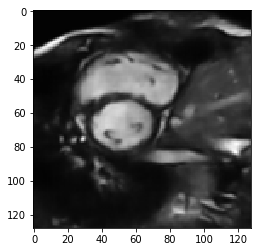

saving epoch {97}
Epoch: 98, Iteration: 1, Loss: 0.0005324745434336364, time: 2019-08-03 13:19:34.354068
Epoch: 98, Iteration: 101, Loss: 0.05992936936672777, time: 2019-08-03 13:21:10.128961
150
2019-08-03 13:21:57.050716 Epoch 98, Training loss 0.09099910518852994
torch.Size([1, 1, 128, 128, 20])


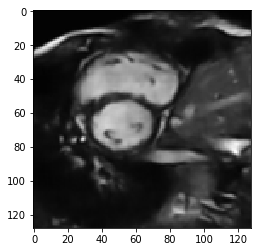

saving epoch {98}
Epoch: 99, Iteration: 1, Loss: 0.0005302197532728314, time: 2019-08-03 13:21:58.197446
Epoch: 99, Iteration: 101, Loss: 0.06354324702988379, time: 2019-08-03 13:23:33.924903
150
2019-08-03 13:24:20.852925 Epoch 99, Training loss 0.09475375572219491
torch.Size([1, 1, 128, 128, 20])


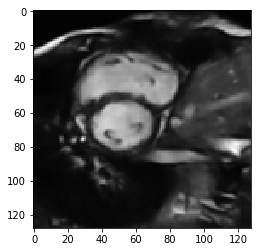

saving epoch {99}
Epoch: 100, Iteration: 1, Loss: 0.0005902965785935521, time: 2019-08-03 13:24:21.996757
Epoch: 100, Iteration: 101, Loss: 0.07736322918208316, time: 2019-08-03 13:25:57.761119
150
2019-08-03 13:26:44.712407 Epoch 100, Training loss 0.1105164346517995
torch.Size([1, 1, 128, 128, 20])


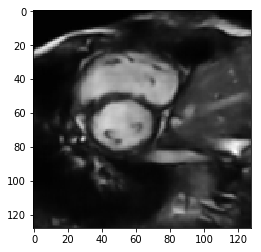

saving epoch {100}


In [40]:
training_loop(100, optimizer, model, loss_fn, train_loader)

# Training done

# Testing

In [41]:
len(loss_vec)

100

Text(0, 0.5, 'MSE error')

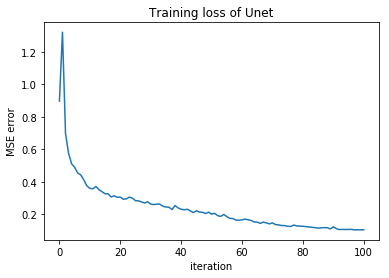

In [62]:
plt.plot(np.arange(101), loss_vec)
plt.title("Training loss of Unet")
plt.xlabel('iteration')
plt.ylabel('MSE error')

Text(0, 0.5, 'MSE error')

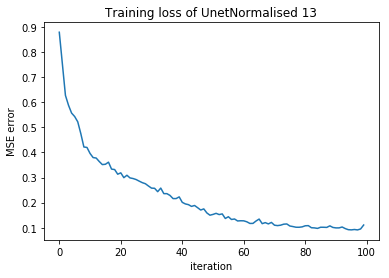

In [43]:
plt.plot(np.arange(100), loss_vec)
plt.title("Training loss of UnetNormalised 13")
plt.xlabel('iteration')
plt.ylabel('MSE error')

In [45]:
result_vec = []

In [46]:
for k in range(222):
    a = test_recon[k:k+1,:,:,:,:]
    a = a.float()
    result = model(a.to(device))
    result = result.to('cpu')
    result = result.detach()
    result = result.numpy()
    result_vec.append(result)

In [47]:
len(result_vec)

222

In [48]:
res_save = np.ndarray((128,128,200,222))

In [49]:
a = torch.FloatTensor(result_vec)

In [50]:
a.shape

torch.Size([222, 1, 1, 128, 128, 20])

In [51]:
a = a.permute(0,3,4,5,1,2)

In [52]:
b = a[:,:,:,:,0,0]

In [53]:
b.shape

torch.Size([222, 128, 128, 20])

In [54]:
b = b.numpy()

In [55]:
import scipy.io

In [56]:
scipy.io.savemat('Results_unetNormalised_13und_100epoch.mat', {'recon':b})

In [57]:
result_vec[0].shape

(1, 1, 128, 128, 20)

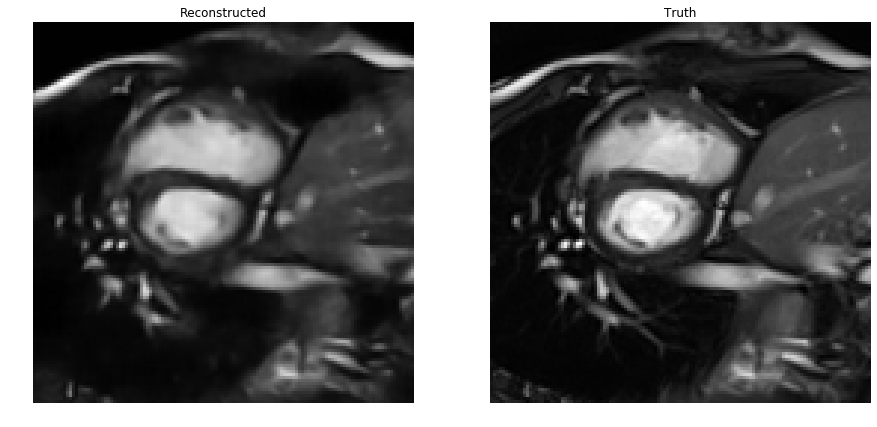

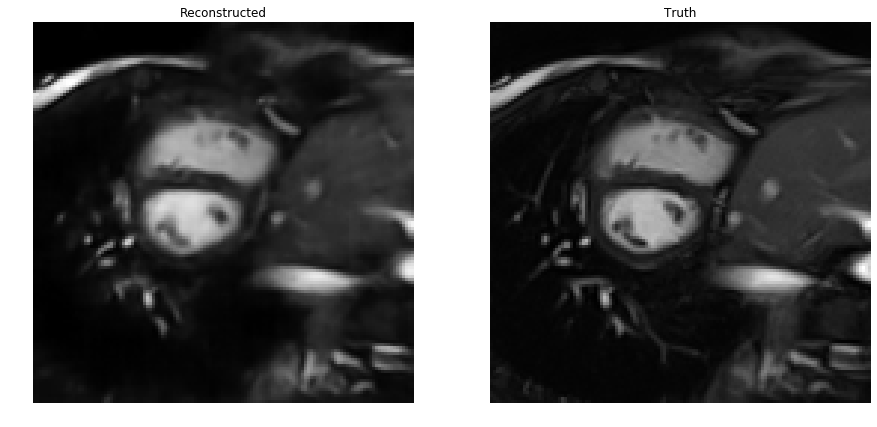

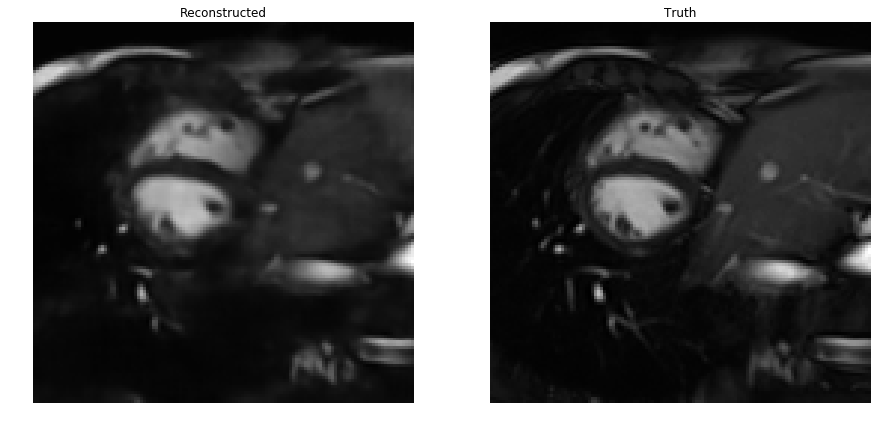

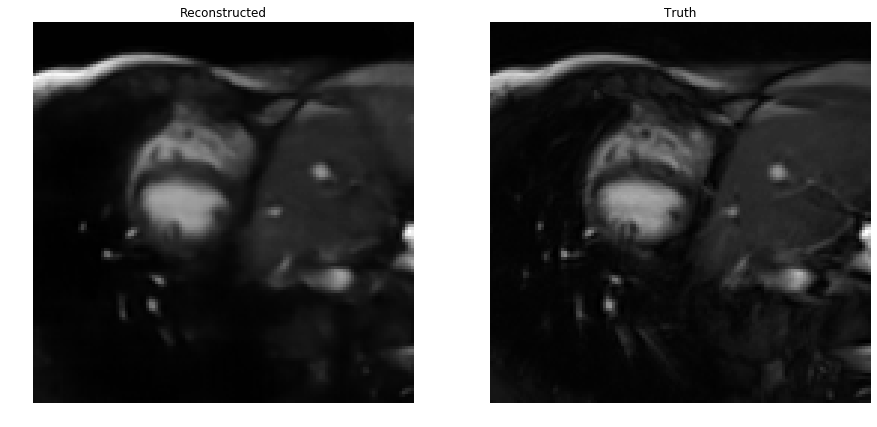

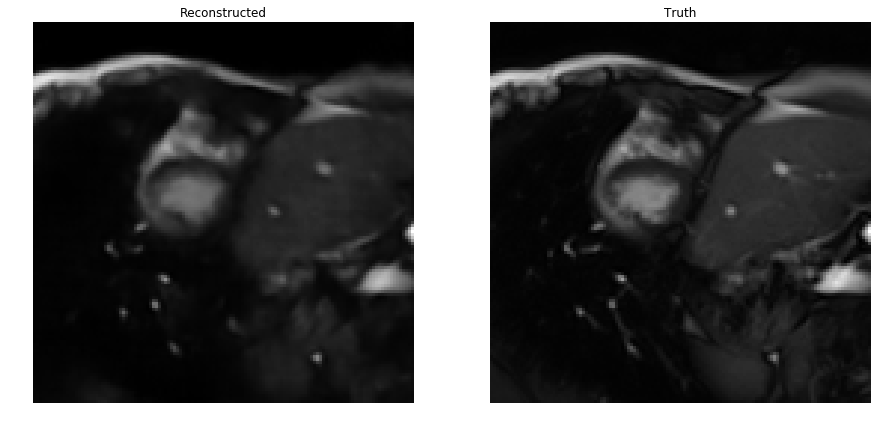

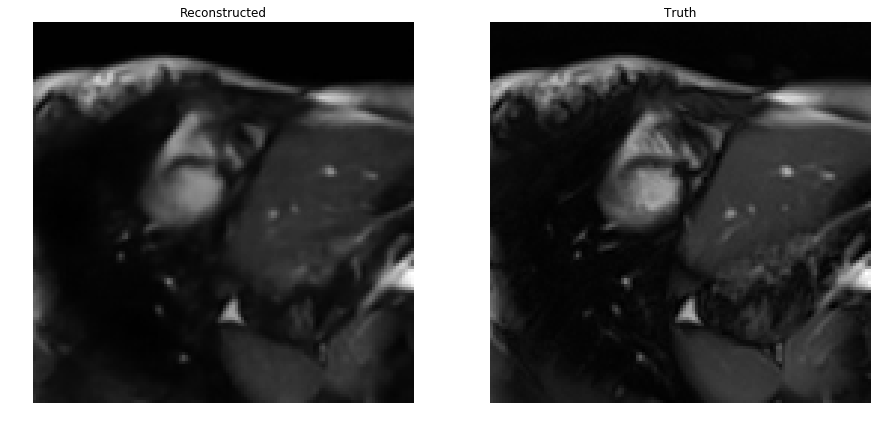

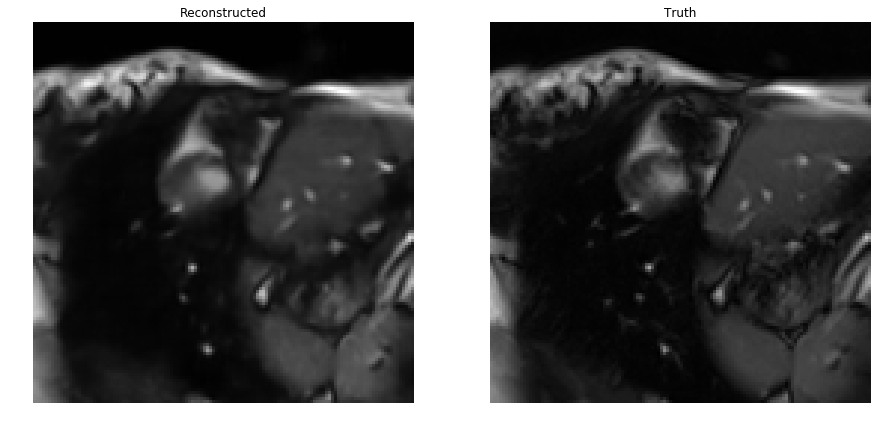

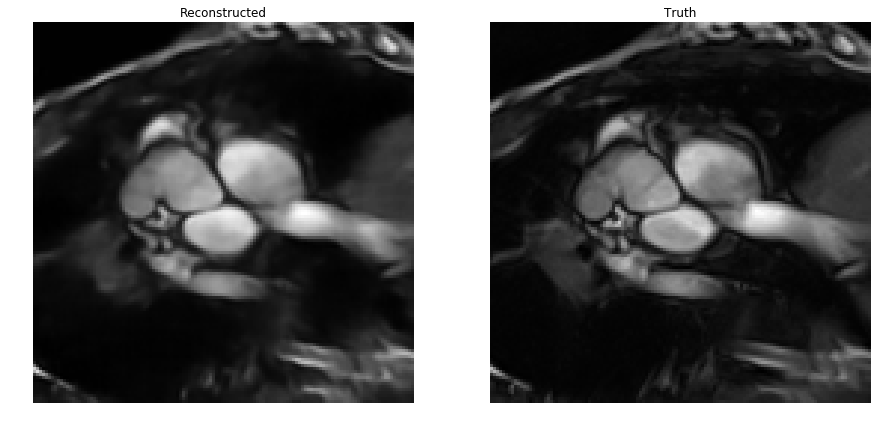

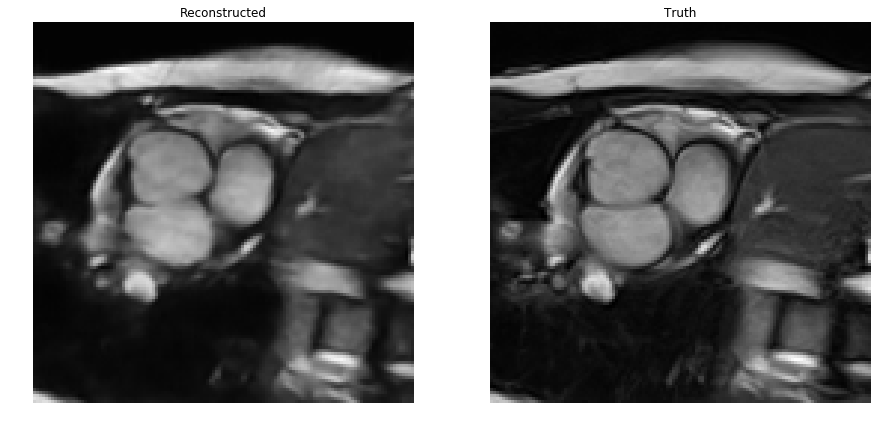

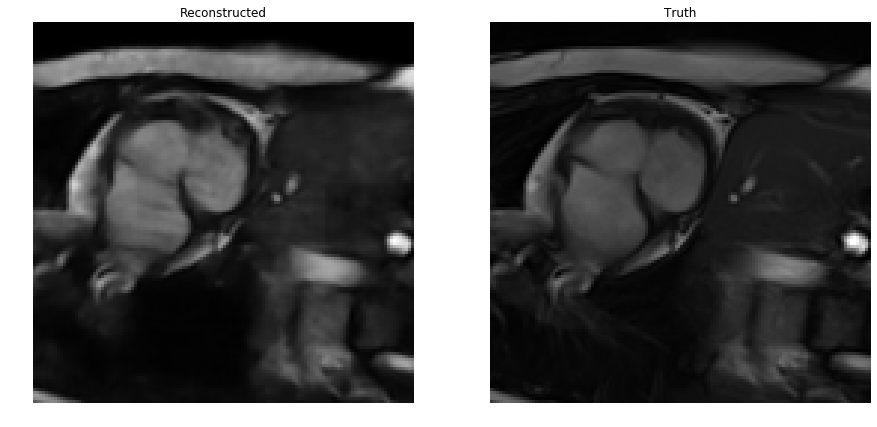

In [58]:
for k in range(10):
# Let's look at a smaple data again to check everything is the same
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(result_vec[k][0,0,:,:,10], cmap='gray')
    arr[0].set_title("Reconstructed")
    arr[0].axis('off')
    arr[1].imshow(test_true[k,0,:,:,10], cmap='gray')
    arr[1].set_title("Truth")
    arr[1].axis('off');

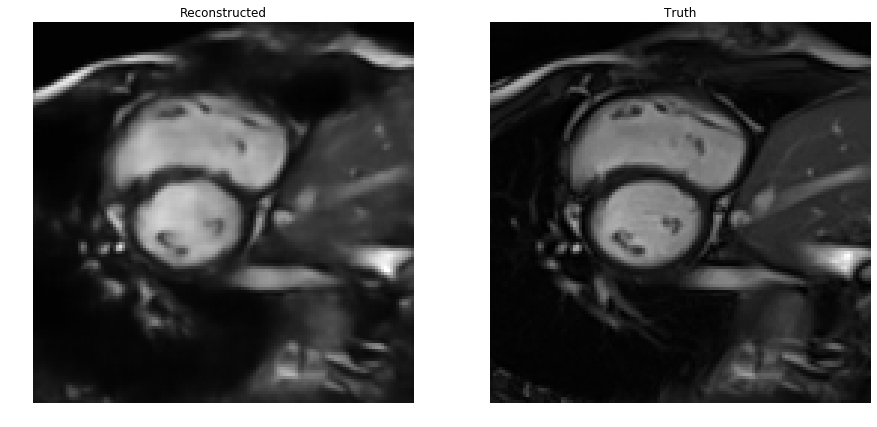

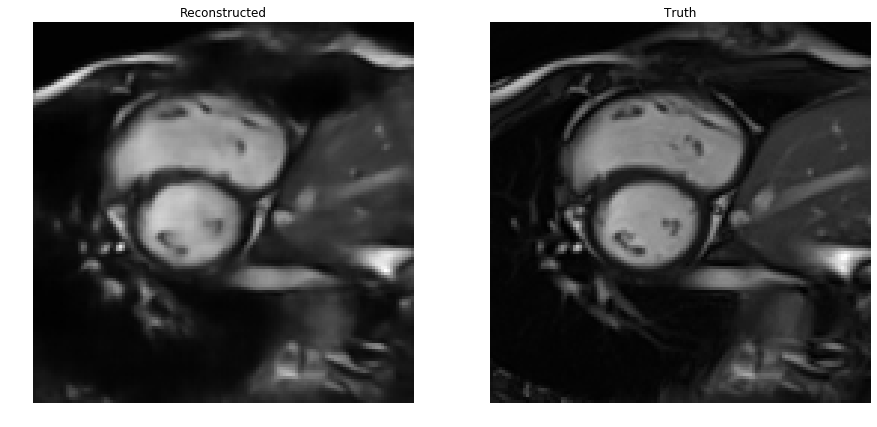

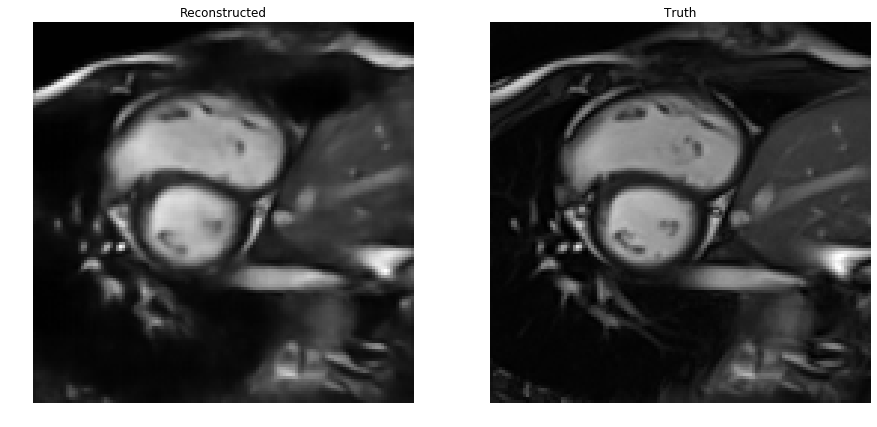

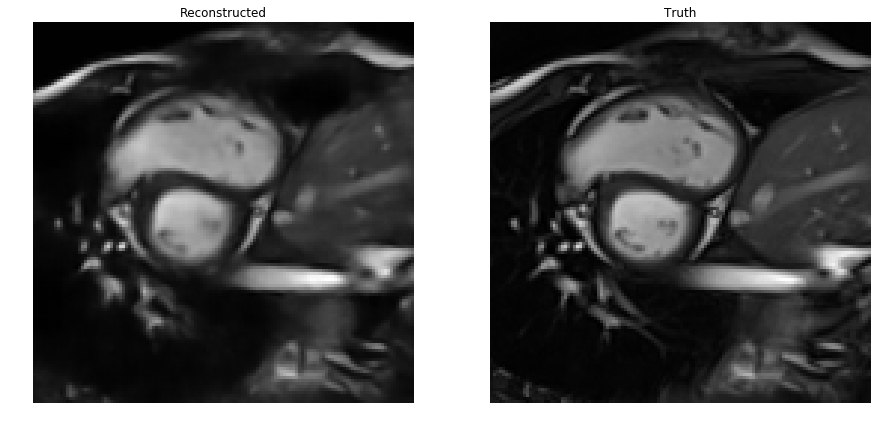

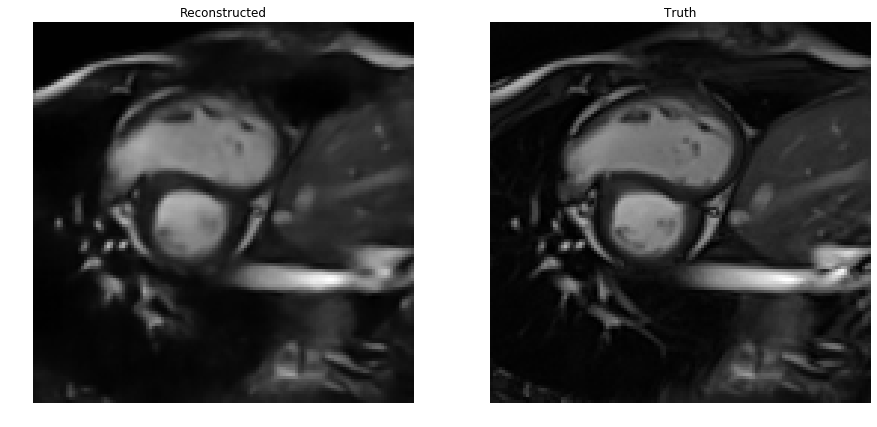

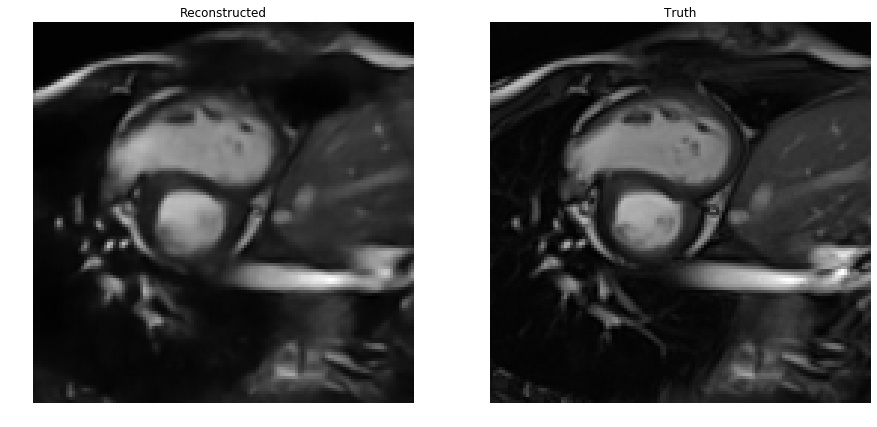

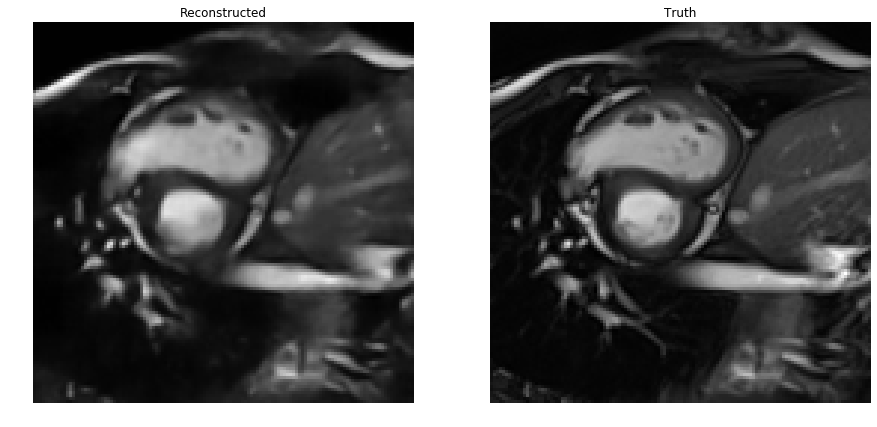

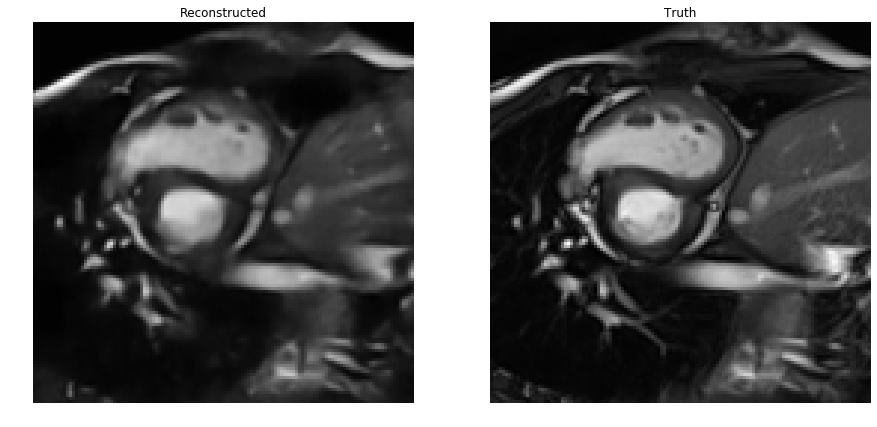

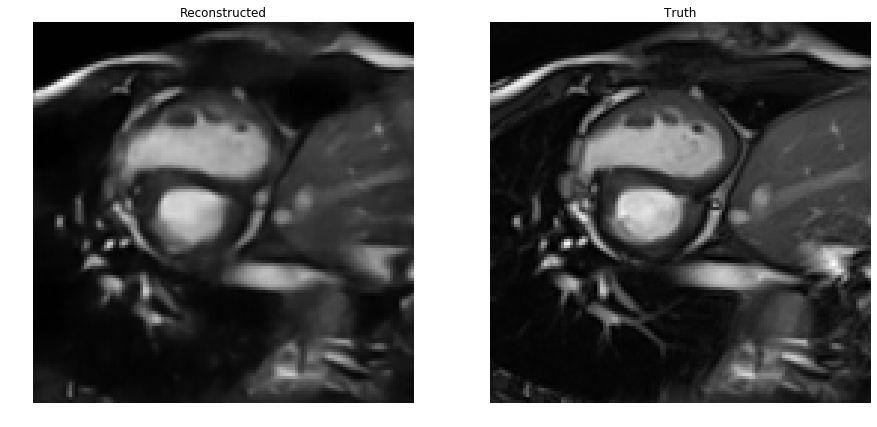

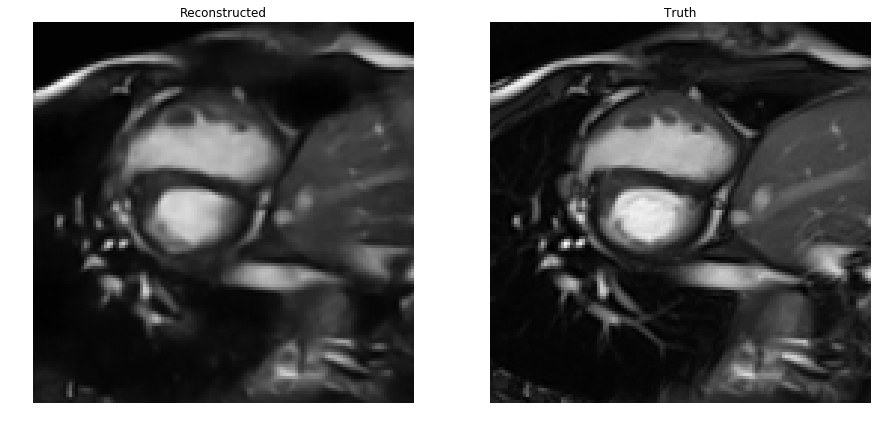

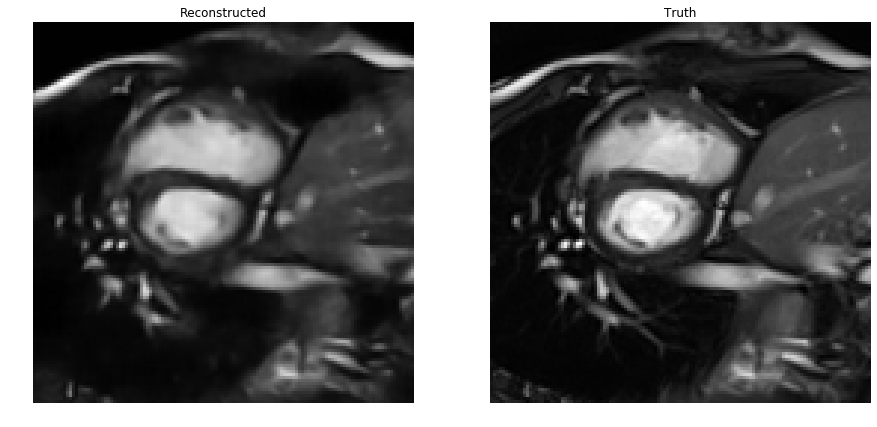

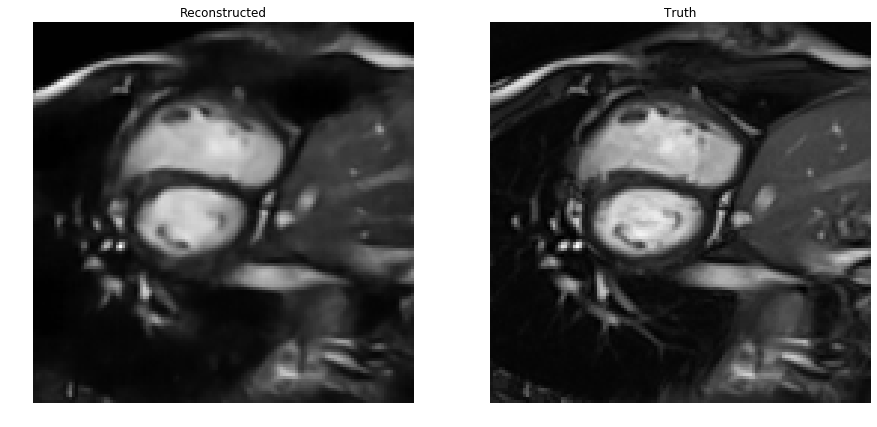

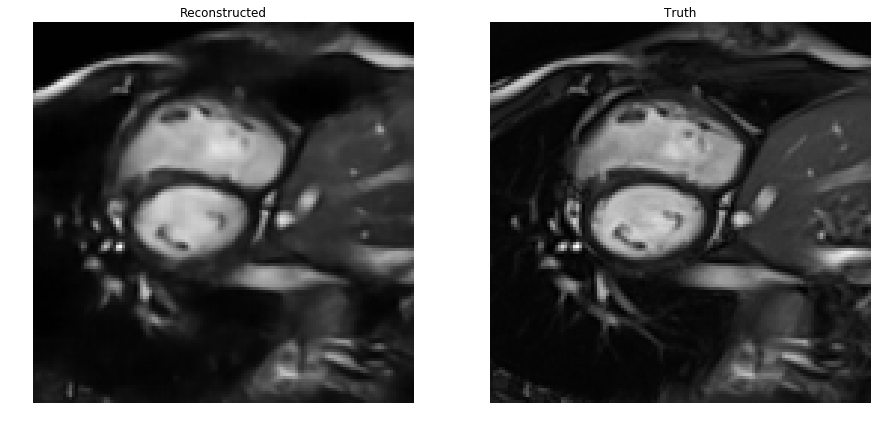

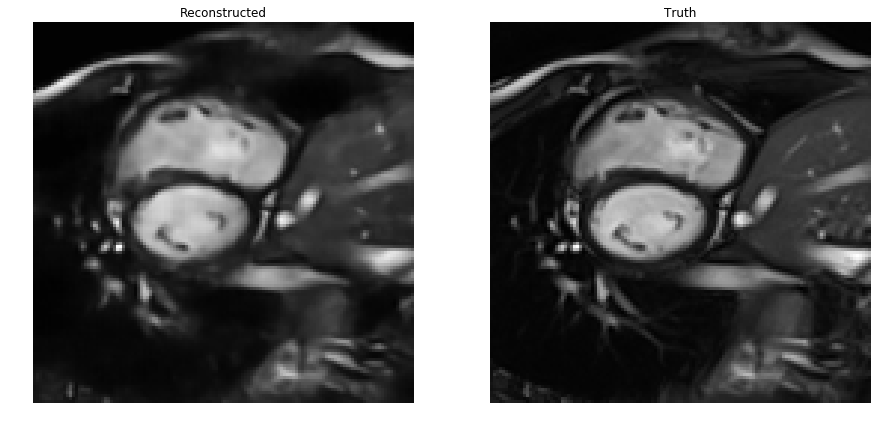

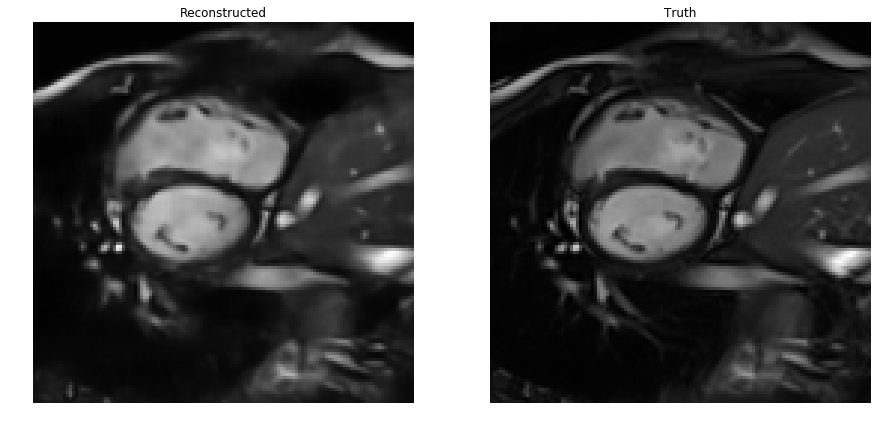

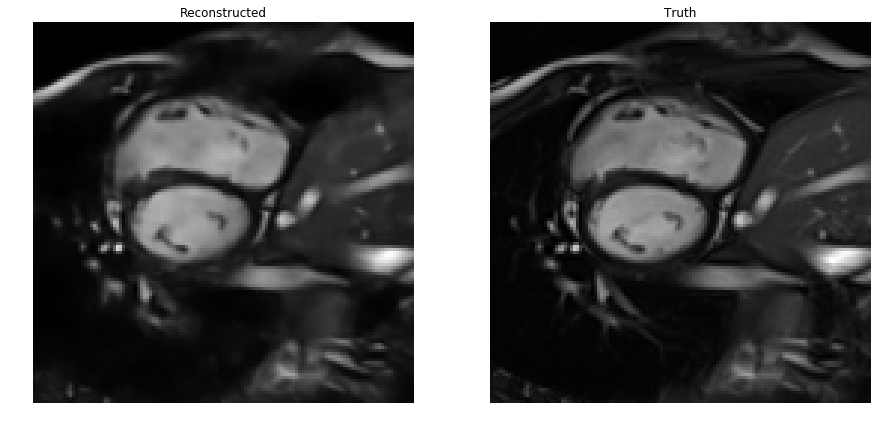

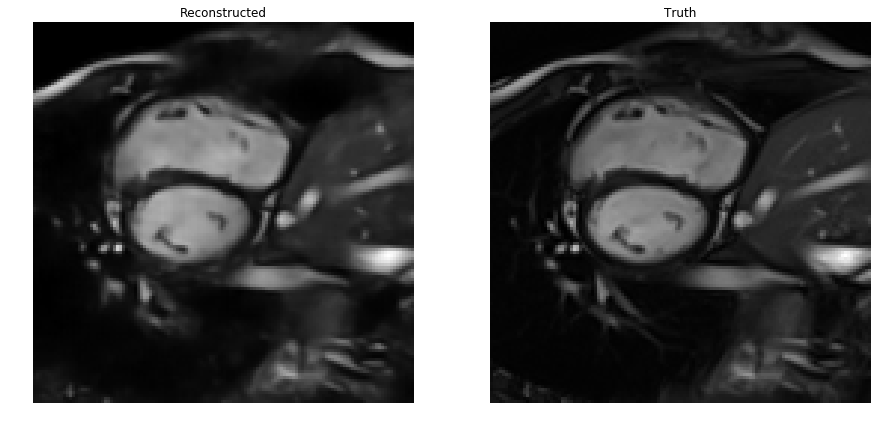

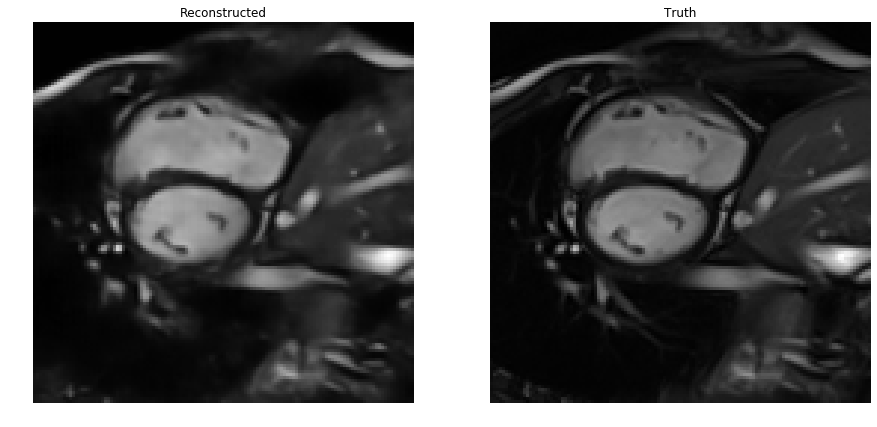

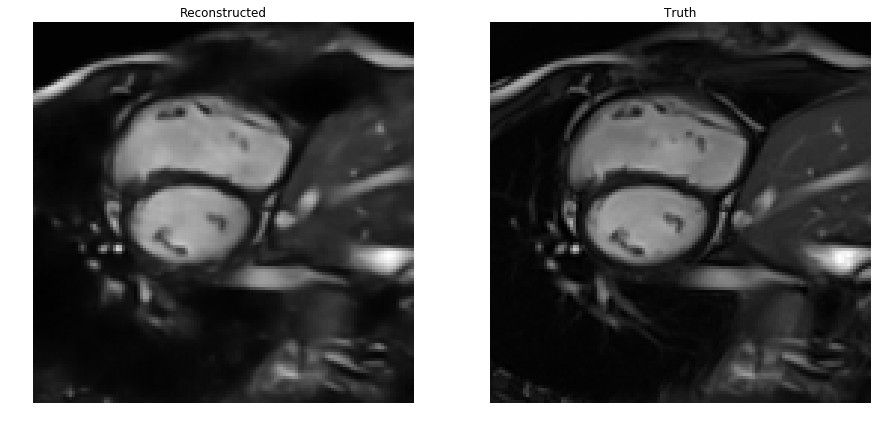

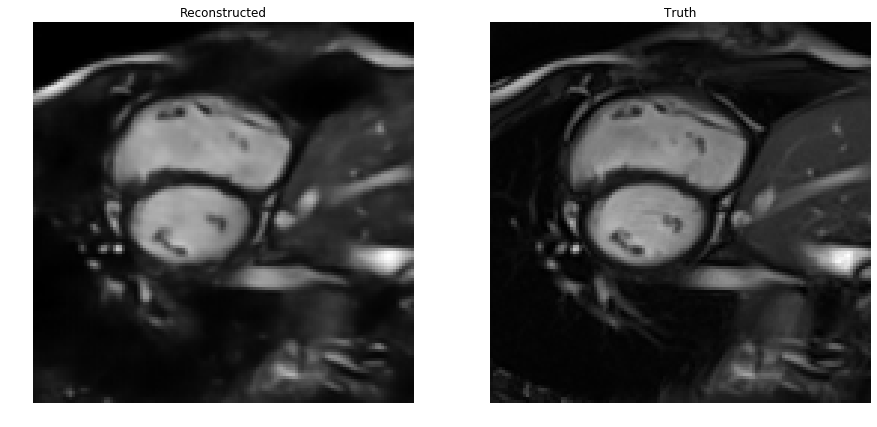

In [59]:
for k in range(20):
# Let's look at a smaple data again to check everything is the same
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(result_vec[0][0,0,:,:,k], cmap='gray')
    arr[0].set_title("Reconstructed")
    arr[0].axis('off')
    arr[1].imshow(test_true[0,0,:,:,k], cmap='gray')
    arr[1].set_title("Truth")
    arr[1].axis('off');